<a href="https://colab.research.google.com/github/slopatek/Crude_Oil_Prices_Time_Series_Analysis/blob/main/Brent_Basic_TA_Strategies_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Brent - simple TA strategies**

 The purpose of the notebook is to explore the potential of simple technical analysis trading strategies on the oil market, specyfically with reference to ICE Brent.

# **Imports**

Let's import usual suspects so we have proper tools at our disposal

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from itertools import product
import random
import warnings
warnings.filterwarnings('ignore')
cost_value = 10 # 10 USD per lot of 1000 bbls translating into 0,01 USD/bbl

# **Data**

This is just to show the data we will be working with but our process will be set up in such a way that data will be loaded into the data atribute of an instance of a class @ initialization

In [ ]:
!wget https://raw.githubusercontent.com/slopatek/Crude_Oil_Prices_Time_Series_Analysis/main/Brent_Feed_CSV.csv

df = pd.read_csv('Brent_Feed_CSV.csv', encoding = "ISO-8859-1", sep =";", decimal=",", parse_dates = ["date"],
                 index_col="date", converters = {'expiry_day' : lambda x: True if x == 'PRAWDA' else False})
df

--2023-08-08 14:17:18--  https://raw.githubusercontent.com/slopatek/Crude_Oil_Prices_Time_Series_Analysis/main/Brent_Feed_CSV.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 335899 (328K) [text/plain]
Saving to: ‘Brent_Feed_CSV.csv’

Brent_Feed_CSV.csv  100%[===================>] 328.03K  --.-KB/s    in 0.04s   

2023-08-08 14:17:18 (8.04 MB/s) - ‘Brent_Feed_CSV.csv’ saved [335899/335899]



,brent_m1,brent_bid_m1,brent_ask_m1,brent_m2,brent_bid_m2,brent_ask_m2,expiry_day,volume
date,,,,,,,,
2002-12-30,29.28,29.275,29.285,28.33,28.320,28.340,False,23037
2003-01-02,29.43,29.425,29.435,28.48,28.470,28.490,False,20943
2003-01-03,30.77,30.760,30.780,29.59,29.575,29.605,False,23163
2003-01-06,30.20,30.165,30.235,28.92,28.880,28.960,False,32675
2003-01-07,29.33,29.290,29.370,28.37,28.325,28.415,False,40642
...,...,...,...,...,...,...,...,...
2023-07-25,83.64,83.640,83.640,100.47,100.470,100.470,False,311655
2023-07-26,82.92,82.920,82.920,101.47,101.470,101.470,False,333939
2023-07-27,84.24,84.240,84.240,102.47,102.470,102.470,False,354644


# **Generic Class**

I have chosen to proceed with object oriented programming here. All strategies to be tested share some common features which will be defined in a super (mother) class of *trading_strategy*

In [ ]:
class trading_strategy():
  '''Generic class serving as base for testing various trading strategies
  '''

  def __init__(self, start, end, cost=cost_value):
    '''
    Input parameters:
    -----------------
    start: str
        start date
    end: str
        end date
    cost: float
        transaction costs expressed in USD per lot (1000 bbl)
    '''
    self.start = start
    self.end = end
    self.cost = cost / 1000 # cost per barrel
    self.load_data()
    self.results = False
    self.full_data = None

  def __repr__(self):
    return f'Base object facilitating tests of a given trading strategy from {self.start} till {self.end}'

  def load_data(self):
    ''' Loads data from a csv file into a data frame
    '''
    df = pd.read_csv('Brent_Feed_CSV.csv', encoding = "ISO-8859-1", sep =";", decimal=",", parse_dates = ["date"],
                 index_col="date", converters = {'expiry_day' : lambda x: True if x == 'PRAWDA' else False})
    df = df.dropna()
    self.data = df.copy()

#**Buy & Hold**
The least sophisticated strategy that I can imagine is:

*   buying an asset at the begining of a period
*   holding it throughout the period
*   selling an asset at the end of a period tested

It will serve as a baseline reference throughout the notebook.

The flavor here is that we have to roll the front month futures contract @ expiry (with corresponding roll return) to maintain long position.
Let's put it into code then...

In [ ]:
class buy_and_hold(trading_strategy):
  ''' Class for testing buy-and-hold strategy
  '''
  def __init__(self, start, end, cost = cost_value):
    '''
    No additional parameters required
    ---------------------------------
    '''
    super().__init__(start, end, cost) # inheriting 3 arguments from mother-class of trading strategy
    self.outcome = None
    self.results = False

  def __repr__(self):
    return f'Object designed to test buy-and-hold strategy from {self.start} till {self.end}'

  def prepare_data(self):
    df = self.data.copy()

    conditions = [df.index == df.index[df.index.get_indexer([self.start], method = 'bfill')[0]],
                  df.index == df.index[df.index.get_indexer([self.end], method = 'ffill')[0]],
                  (df.index > self.start) & (df.index < self.end) & (df['expiry_day'] == True)]
    values = ['buy', 'sell', 'roll']
    df['action'] = np.select(conditions, values, default='hold')

    df['position'] = 0
    df.iloc[df.index.get_indexer([self.start], method = 'bfill')[0] : df.index.get_indexer([self.end], method = 'ffill')[0], df.columns.get_loc("position")] = 1
    df['trades'] = df['position'].diff().fillna(0).abs().astype('int32')
    df.loc[df['action'] == 'roll','trades'] = 2
    df['costs'] = df['trades'] * self.cost
    conditions = [(df['expiry_day']== False) & (df['action'] == 'buy'),
                  (df['expiry_day']== True) & (df['action'] == 'buy'),
                  (df['expiry_day']== False) & (df['action'] == 'sell'),
                  (df['expiry_day']== True) & (df['action'] == 'sell'),
                  (df['expiry_day']== False) & (df['action'] == 'hold'),
                  (df['expiry_day']== True) & (df['action'] == 'roll')]
    values = [df['brent_ask_m1'], df['brent_ask_m2'],
              df['brent_bid_m1'], df['brent_bid_m1'],
              df['brent_m1'], (df['brent_bid_m1']+df['brent_ask_m2'])/2]
    df['price'] = np.select(conditions, values, default = df['brent_m1'])
    # df = df.dropna()
    self.full_data = df.iloc[df.index.get_indexer([self.start], method = 'bfill')[0]-1 : df.index.get_indexer([self.end], method = 'ffill')[0]+1].copy() # 1 extra day

  def test_strategy(self):
    ''' Performs a backtest of the buy-and-hold strategy for a given period
    '''
    if self.full_data is None:
      self.prepare_data()
    df = self.full_data.copy()

    conditions = [df['action'].shift(1) == 'buy',
                  df['action'] == 'roll',
                  (df['action'].shift(1) == 'roll') & (df['action'] == 'hold'),
                  df['action'] == 'sell']
    values = [np.log(df['price']/(df['price'].shift(1)+self.cost)),
              np.log((2*df['brent_bid_m1']-df['brent_ask_m2']-self.cost) / df['brent_m1'].shift(1)),
              np.log(df['brent_m1'] / (df['brent_ask_m2'].shift(1)+self.cost)),
              np.log((df['price'] - self.cost)/(df['price'].shift(1)))]
    df['returns'] = np.select(conditions, values, default = np.log(df['price']/df['price'].shift(1)))
    df['returns'] = df['position'].shift(1) * df['returns']
    df["cum_returns"] = df["returns"].cumsum().apply(np.exp)
    self.full_data = df.loc[self.start : self.end].copy()
    outcome = (df.iloc[df.index.get_indexer([self.end], method = 'ffill')[0], df.columns.get_loc("cum_returns")]-1)*100
    self.outcome = outcome
    self.results = True
    return round(outcome,4)

  def plot_results(self, axis):
    ''' Plots the results of the strategy
    '''
    if self.results == False:
      self.test_strategy()
    if self.outcome >=0:
      result_color = 'dimgray'
    else:
      result_color = 'firebrick'

    axis.plot(self.full_data['cum_returns'], color='firebrick', label = 'cum return')
    axis.set_title(f'FY{self.start[:4]}', fontsize = 12, fontweight="bold", color = 'dimgray')
    axis.set_xticklabels([])
    axis.legend(loc='best', fontsize = 8, labelcolor='dimgray')
    axis.annotate(f'{self.outcome:.2f}%', xy=(0.92, 1.04), xycoords="axes fraction", size = 12, fontweight="bold", color = result_color, va="center", ha="center", alpha = 1);


Let's try an instance of the class for an arbitrarly chosen period encompasing both bear and bull markets

In [ ]:
buy_hold_tester=buy_and_hold('2020-01-01', '2022-12-31')
buy_hold_tester

Object designed to test buy-and-hold strategy from 2020-01-01 till 2022-12-31

... and check it's data atribute

In [ ]:
buy_hold_tester.data

,brent_m1,brent_bid_m1,brent_ask_m1,brent_m2,brent_bid_m2,brent_ask_m2,expiry_day,volume
date,,,,,,,,
2002-12-30,29.28,29.275,29.285,28.33,28.320,28.340,False,23037
2003-01-02,29.43,29.425,29.435,28.48,28.470,28.490,False,20943
2003-01-03,30.77,30.760,30.780,29.59,29.575,29.605,False,23163
2003-01-06,30.20,30.165,30.235,28.92,28.880,28.960,False,32675
2003-01-07,29.33,29.290,29.370,28.37,28.325,28.415,False,40642
...,...,...,...,...,...,...,...,...
2023-07-25,83.64,83.640,83.640,100.47,100.470,100.470,False,311655
2023-07-26,82.92,82.920,82.920,101.47,101.470,101.470,False,333939
2023-07-27,84.24,84.240,84.240,102.47,102.470,102.470,False,354644


Some expansion of the dataset is necessary before the strategy is tested

In [ ]:
buy_hold_tester.prepare_data()
buy_hold_tester.full_data

,brent_m1,brent_bid_m1,brent_ask_m1,brent_m2,brent_bid_m2,brent_ask_m2,expiry_day,volume,action,position,trades,costs,price
date,,,,,,,,,,,,,
2019-12-31,66.00,65.995,66.005,65.29,65.280,65.300,False,54805,hold,0,0,0.00,66.000
2020-01-02,66.25,66.190,66.310,65.56,65.495,65.625,False,81185,buy,1,1,0.01,66.310
2020-01-03,68.60,68.590,68.610,67.76,67.745,67.775,False,202661,hold,1,0,0.00,68.600
2020-01-06,68.91,68.890,68.930,68.07,68.045,68.095,False,152513,hold,1,0,0.00,68.910
2020-01-07,68.27,68.260,68.280,67.57,67.555,67.585,False,142789,hold,1,0,0.00,68.270
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-23,83.92,83.910,83.930,84.50,84.490,84.510,False,180396,hold,1,0,0.00,83.920
2022-12-27,84.33,84.275,84.385,84.68,84.635,84.725,False,160090,hold,1,0,0.00,84.330
2022-12-28,83.26,83.140,83.380,83.99,83.900,84.080,False,211211,hold,1,0,0.00,83.260


Let's see what it would give us...

In [ ]:
buy_hold_tester.test_strategy()

47.8592

Daily returns and cumulative returns are available here

In [ ]:
buy_hold_tester.full_data

,brent_m1,brent_bid_m1,brent_ask_m1,brent_m2,brent_bid_m2,brent_ask_m2,expiry_day,volume,action,position,trades,costs,price,returns,cum_returns
date,,,,,,,,,,,,,,,
2020-01-02,66.25,66.190,66.310,65.56,65.495,65.625,False,81185,buy,1,1,0.01,66.310,0.000000,1.000000
2020-01-03,68.60,68.590,68.610,67.76,67.745,67.775,False,202661,hold,1,0,0.00,68.600,0.033801,1.034379
2020-01-06,68.91,68.890,68.930,68.07,68.045,68.095,False,152513,hold,1,0,0.00,68.910,0.004509,1.039053
2020-01-07,68.27,68.260,68.280,67.57,67.555,67.585,False,142789,hold,1,0,0.00,68.270,-0.009331,1.029403
2020-01-08,65.44,65.410,65.470,64.79,64.755,64.825,False,270031,hold,1,0,0.00,65.440,-0.042337,0.986731
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-23,83.92,83.910,83.930,84.50,84.490,84.510,False,180396,hold,1,0,0.00,83.920,0.035662,1.478771
2022-12-27,84.33,84.275,84.385,84.68,84.635,84.725,False,160090,hold,1,0,0.00,84.330,0.004874,1.485996
2022-12-28,83.26,83.140,83.380,83.99,83.900,84.080,False,211211,hold,1,0,0.00,83.260,-0.012769,1.467141


Unsurprisingly cumulative rate of return tracks price marker fairly well. The other major factor determining final return is a roll return:
*   positive in case of backwardation
*   negative in case of contango

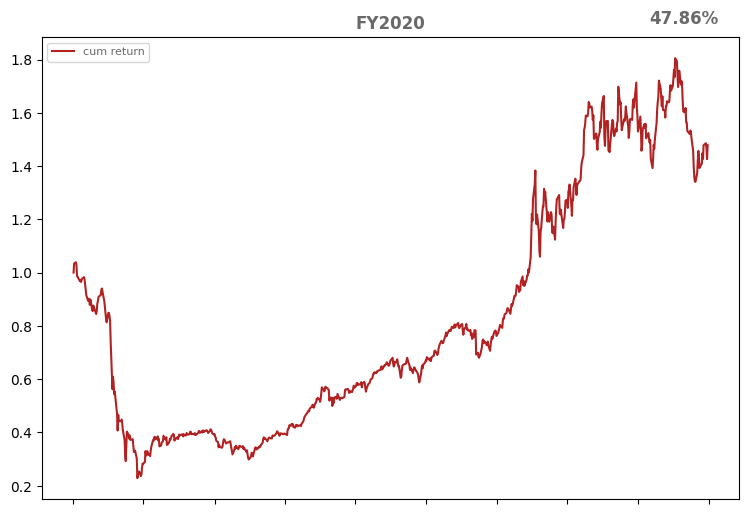

In [ ]:
fig, ax = plt.subplots(figsize=(9,6), dpi=100)
buy_hold_tester.plot_results(ax)

But that's just one arbitraly chosen 3-year long period. Let's have a better feel with a wider range of outcomes for randomly selected annual periods. A return for a relevant period printed in the upper right corner of the chart...

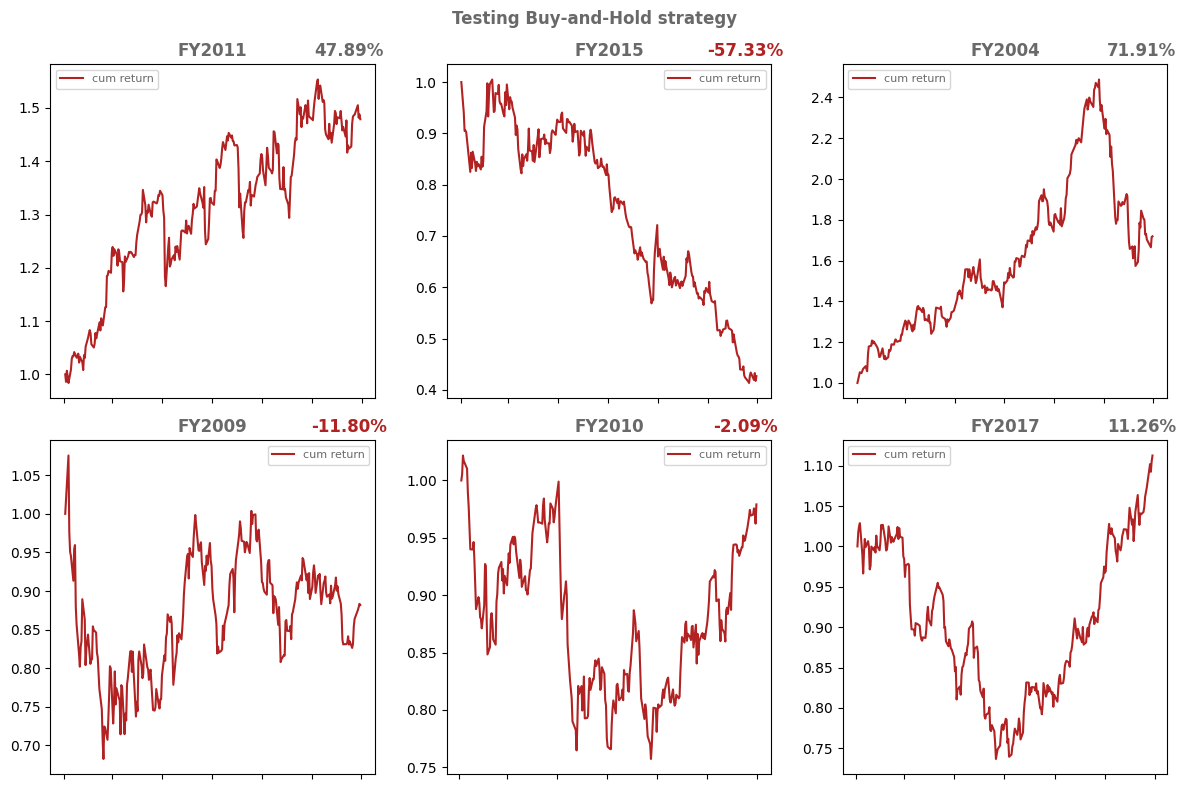

In [ ]:
fig, axes = plt.subplots(nrows = 2, ncols = 3, figsize=(12,8), dpi=100)
fig.suptitle("Testing Buy-and-Hold strategy", fontsize=12, fontweight="bold", color = 'dimgray', y=0.98)

year_list = list(np.arange(2004,2022))
year_sample = random.sample(year_list,len(axes.ravel()))

for year_choice, ax in zip(year_sample,axes.ravel()):
  # year_choice = random.choice(year_list)
  start_point, end_point = str(year_choice) + '-01-01', str(year_choice) + '-12-31'
  buy_hold_tester = buy_and_hold(start_point, end_point)
  buy_hold_tester.plot_results(ax)
plt.tight_layout()

# **MA Crossover**

Like the old trader's adage goes: a trend is a friend. It would be useful to identify it on time. Moving Average cross-over strategy dictates to take a long position when short-term moving average is above long-term average. Consequently short position is advised in the oposite case. Lets put it into code...

In [ ]:
class ma_crossover(trading_strategy):
  ''' Class for testing moving average crossover strategy
  '''
  def __init__(self, short_ma, long_ma, start, end, cost = cost_value, baseline = True):
    '''
    Additional parameters:
    -----------------
    short_ma: int
        lenght of short-term moving average
    long_ma: int
        lenght of long-term moving average
    '''
    super().__init__(start, end, cost) # inheriting 3 arguments from mother-class of trading strategy
    self.short_ma = short_ma
    self.long_ma = long_ma
    self.baseline = baseline
    self.outcome = None
    self.excesss_return = 0

  def __repr__(self):
    return f'Object designed to test moving average crossover strategy from {self.start} till {self.end}'

  def prepare_data(self):
    df = self.data.copy()
    df['short_ma'] = df['brent_m1'].rolling(self.short_ma).mean()
    df['long_ma'] = df['brent_m1'].rolling(self.long_ma).mean()
    df["position"] = np.where(df["short_ma"] > df["long_ma"], 1, -1)

    conditions = [((df["position"] - df['position'].shift(1)) == 2) & (df['expiry_day']==False),
                  ((df["position"] - df['position'].shift(1)) == -2) & (df['expiry_day']==False),
                  ((df["position"] - df['position'].shift(1)) == 2) & (df['expiry_day']==True),
                  ((df["position"] - df['position'].shift(1)) == -2) & (df['expiry_day']==True),
                  ((df["position"] - df['position'].shift(1)) == 0) & (df['expiry_day']==False),
                  ((df["position"] - df['position'].shift(1)) == 0) & (df['expiry_day']==True)]
    values = ['go_long','go_short', 'go_long', 'go_short', 'hold', 'roll']
    df['action'] = np.select(conditions, values, default = 'hold')
    if df.iloc[df.index.get_indexer([self.start], method = 'bfill')[0], df.columns.get_loc("position")] == 1:
      df.iloc[df.index.get_indexer([self.start], method = 'bfill')[0], df.columns.get_loc("action")] = 'go_long'
    if df.iloc[df.index.get_indexer([self.start], method = 'bfill')[0], df.columns.get_loc("position")] == -1:
      df.iloc[df.index.get_indexer([self.start], method = 'bfill')[0], df.columns.get_loc("action")] = 'go_short'

    df['trades'] = df['position'].diff().fillna(0).abs().astype('int32')
    df.loc[df['action'] == 'roll','trades'] = 2
    df['costs'] = df['trades'] * self.cost

    conditions = [(df['expiry_day']== False) & (df['action'] == 'go_short'),
                  (df['expiry_day']== True) & (df['action'] == 'go short'),
                  (df['expiry_day']== False) & (df['action'] == 'go_long'),
                  (df['expiry_day']== True) & (df['action'] == 'go_long'),
                  (df['expiry_day']== True) & (df['action'] == 'roll')]
    values = [df['brent_bid_m1'], (df['brent_bid_m1']+df['brent_bid_m2'])/2,
              df['brent_ask_m1'], (df['brent_ask_m1']+df['brent_ask_m2'])/2,
              (df['brent_bid_m1']+df['brent_ask_m2'])/2]
    df['price'] = np.select(conditions, values, default = df['brent_m1'])
    df = df.dropna()
    df['buy_signal'] = np.where(df['action']=='go_long',df['price'],np.nan)
    df['sell_signal'] = np.where(df['action']=='go_short',df['price'],np.nan)

    if self.baseline == True:
      conditions = [df.index == df.index[df.index.get_indexer([self.start], method = 'bfill')[0]],
                  df.index == df.index[df.index.get_indexer([self.end], method = 'ffill')[0]],
                  (df.index > self.start) & (df.index < self.end) & (df['expiry_day'] == True)]
      values = ['buy', 'sell', 'roll']
      df['base_action'] = np.select(conditions, values, default='hold')
      df['base_position'] = 0
      df.iloc[df.index.get_indexer([self.start], method = 'bfill')[0] : df.index.get_indexer([self.end], method = 'ffill')[0], df.columns.get_loc("base_position")] = 1
      df['base_trades'] = df['base_position'].diff().fillna(0).abs().astype('int32')
      df.loc[df['base_action'] == 'roll','base_trades'] = 2
      df['base_costs'] = df['base_trades'] * self.cost
      conditions = [(df['expiry_day']== False) & (df['base_action'] == 'buy'),
                    (df['expiry_day']== True) & (df['base_action'] == 'buy'),
                    (df['expiry_day']== False) & (df['base_action'] == 'sell'),
                    (df['expiry_day']== True) & (df['base_action'] == 'sell'),
                    (df['expiry_day']== False) & (df['base_action'] == 'hold'),
                    (df['expiry_day']== True) & (df['base_action'] == 'roll')]
      values = [df['brent_ask_m1'], df['brent_ask_m2'],
                df['brent_bid_m1'], df['brent_bid_m1'],
                df['brent_m1'], (df['brent_bid_m1']+df['brent_ask_m2'])/2]
      df['base_price'] = np.select(conditions, values, default = df['brent_m1'])
    self.full_data = df.iloc[df.index.get_indexer([self.start], method = 'bfill')[0]-1 : df.index.get_indexer([self.end], method = 'ffill')[0]+1].copy()


  def set_params(self, new_short_ma = None, new_long_ma = None):
    ''' Modifies settings regarding short-term and long-term moving averages
    '''
    if new_short_ma is not None:
      self.short_ma = new_short_ma
    if new_long_ma is not None:
      self.long_ma = new_long_ma
    self.prepare_data()

  def test_strategy(self):
    ''' Performs a backtest of the moving average cross-over strategy for a given period
    '''
    if self.full_data is None:
      self.prepare_data()
    df = self.full_data.copy()

    conditions = [(df['expiry_day']== False) & (df['action'] == 'go_short'),
                  (df['expiry_day'].shift(1)== False) & (df['action'].shift(1) == 'go_short'),
                  (df['expiry_day']== True) & (df['action'] == 'go_short'),
                  (df['expiry_day'].shift(1)== True) & (df['action'].shift(1) == 'go_short'),
                  (df['expiry_day']== False) & (df['action'] == 'go_long'),
                  (df['expiry_day'].shift(1)== False) & (df['action'].shift(1) == 'go_long'),
                  (df['expiry_day']== True) & (df['action'] == 'go_long'),
                  (df['expiry_day'].shift(1)== True) & (df['action'].shift(1) == 'go_long'),
                  (df['position'] == 1) & (df['action'] == 'roll'),
                  (df['position'].shift(1) == 1) & (df['action'].shift(1) == 'roll'),
                  (df['position'] == -1) & (df['action'] == 'roll'),
                  (df['position'].shift(1) == -1) & (df['action'].shift(1) == 'roll')]
    values = [np.log((df['brent_bid_m1'] - self.cost)/(df['price'].shift(1))),
              np.log(df['price']/(df['brent_bid_m1'].shift(1)-self.cost)),
              np.log((df['brent_bid_m2'] - self.cost)/(df['price'].shift(1))),
              np.log(df['price']/(df['brent_bid_m2'].shift(1)-self.cost)),
              np.log((df['brent_ask_m1'] + self.cost)/(df['price'].shift(1))),
              np.log(df['price']/(df['brent_ask_m1'].shift(1)+self.cost)),
              np.log((df['brent_ask_m2'] + self.cost)/(df['price'].shift(1))),
              np.log(df['price']/(df['brent_ask_m2'].shift(1)+self.cost)),
              np.log((df['brent_bid_m1'] + ((df['brent_bid_m1']-self.cost)-(df['brent_ask_m2']+self.cost))) / (df['price'].shift(1))),
              np.log(df['price']/(df['brent_ask_m2'].shift(1)+self.cost)),
              np.log((df['brent_ask_m1'] + ((df['brent_ask_m1']+self.cost)-(df['brent_bid_m2']-self.cost))) / (df['price'].shift(1))),
              np.log(df['price']/(df['brent_bid_m2'].shift(1)-self.cost))]
    df['returns'] = np.select(conditions, values, default = np.log(df['price']/df['price'].shift(1)))
    df['returns'] = df['position'].shift(1) * df['returns']
    df["cum_returns"] = df["returns"].cumsum().apply(np.exp)
    self.full_data = df
    outcome = (df.iloc[df.index.get_indexer([self.end], method = 'ffill')[0], df.columns.get_loc("cum_returns")]-1)*100
    self.outcome = outcome

    if self.baseline == True:
      conditions = [df['base_action'].shift(1) == 'buy',
                  df['base_action'] == 'roll',
                  (df['base_action'].shift(1) == 'roll') & (df['base_action'] == 'hold'),
                  df['base_action'] == 'sell']
      values = [np.log(df['base_price']/(df['base_price'].shift(1)+self.cost)),
                np.log((2*df['brent_bid_m1']-df['brent_ask_m2']-self.cost) / df['brent_m1'].shift(1)),
                np.log(df['brent_m1'] / (df['brent_ask_m2'].shift(1)+self.cost)),
                np.log((df['base_price'] - self.cost)/(df['base_price'].shift(1)))]
      df['base_returns'] = np.select(conditions, values, default = np.log(df['base_price']/df['base_price'].shift(1)))
      df['base_returns'] = df['base_position'].shift(1) * df['base_returns']
      df["base_cum_returns"] = df["base_returns"].cumsum().apply(np.exp)
      # df = df.loc[self.start : self.end].copy()
      base_outcome = (df.iloc[df.index.get_indexer([self.end], method = 'ffill')[0], df.columns.get_loc("base_cum_returns")]-1)*100
      excess_return = outcome - base_outcome

    self.full_data = df.loc[self.start : self.end].copy()
    self.results = True
    return round(outcome,4), round(excess_return,4)

  def plot_summary(self):
    ''' Plots key charts summarizing the strategy
    '''
    if self.full_data is None:
      print(f'Method prepare_data() must be run in the first place')
    else:
      fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(8,12), dpi=100)
      fig.suptitle(f'{self.start[:4]} - {self.end[:4]} Moving-Average Crossover', fontsize = 14, fontweight="bold", color = 'dimgray')

      ax[0].plot(self.full_data['brent_m1'], color = 'firebrick', label = 'brent m1', alpha = 0.6)
      ax[0].scatter(self.full_data.index, self.full_data['buy_signal'], label = 'buy', marker = '^', alpha = 1, color = 'green')
      ax[0].scatter(self.full_data.index, self.full_data['sell_signal'], label = 'sell', marker = 'v', alpha = 1, color = 'red')
      ax[0].set_title('Price & trading signals', fontsize = 10, fontweight="bold", color = 'dimgray')
      ax[0].set_ylabel(ylabel='USD / bbl',fontsize = 10, color = 'dimgrey', weight = 'bold')
      ax[0].set_xticklabels([])
      ax[0].legend(loc='best', fontsize = 8, labelcolor='dimgray')

      ax[1].plot(self.full_data['short_ma'], color = 'firebrick', label = 'short ma', alpha = 0.9)
      ax[1].plot(self.full_data['long_ma'], color = 'dimgrey', label = 'long ma', alpha = 0.9)
      ax[1].set_title('Moving averages: long-term & short-term', fontsize = 10, fontweight="bold", color = 'dimgray')
      ax[1].set_ylabel(ylabel='USD/bbl',fontsize = 10, color = 'dimgrey', weight = 'bold')
      ax[1].set_xticklabels([])
      ax[1].legend(loc='best',fontsize = 8, labelcolor='dimgray')

      ax[2].plot(self.full_data['position'], color = 'firebrick', label = 'position', alpha = 0.9)
      ax[2].set_title('Trading position', fontsize = 10, fontweight="bold", color = 'dimgray')
      ax[2].set_ylabel(ylabel='Long / short positioning',fontsize = 10, color = 'dimgrey', weight = 'bold')
      ax[2].set_yticks([-1, 0, 1])
      ax[2].set_xticklabels([])
      ax[2].legend(loc='best',fontsize = 8, labelcolor='dimgray')

      ax[3].plot(self.full_data['cum_returns'], color = 'firebrick', label = 'ma crossover', alpha = 0.9)
      ax[3].set_title('Cumulative returns of the strategy', fontsize = 10, fontweight="bold", color = 'dimgray')
      ax[3].set_ylabel(ylabel='Return trajectory',fontsize = 10, color = 'dimgrey', weight = 'bold')
      if self.baseline == True:
        ax[3].plot(self.full_data['base_cum_returns'], color = 'dimgray', label = 'buy & hold', alpha = 0.9)
      ax[3].legend(loc='best',fontsize = 8, labelcolor='dimgray')

      plt.tight_layout()
      plt.savefig('MA_CROSSOVER')

  def plot_results(self, axis):
    ''' Plots the results of the moving average crossover strategy
    '''
    if self.results == False:
      self.test_strategy()
    if self.outcome >=0:
      result_color = 'dimgray'
    else:
      result_color = 'firebrick'

    axis.plot(self.full_data['cum_returns'], color='firebrick', label = 'mov avg crossover')
    if self.baseline == True:
      axis.plot(self.full_data['base_cum_returns'], color='dimgray', label = 'buy-and-hold')
    axis.set_title(f'FY{self.start[:4]}', fontsize = 12, fontweight="bold", color = 'dimgray')
    axis.set_xticklabels([])
    axis.legend(loc='best', fontsize = 8, labelcolor='dimgray')
    axis.annotate(f'{self.outcome:.2f}%', xy=(0.92, 1.04), xycoords="axes fraction", size = 12, fontweight="bold", color = result_color, va="center", ha="center", alpha = 1);

  def optimize_params(self, short_ma_range, long_ma_range):
    '''Searches for optimum short-term / long-term combination for a given period
    Parameters:
    ===========
    short_ma_range: tuple
      assumes the following form (start, end, step)
    long_ma_range: tuple
      assumes the following form (start, end, step)
    '''
    pairs = list(product(range(*short_ma_range), range(*long_ma_range)))

    results = []
    for pair in pairs:
      self.set_params(pair[0], pair[1])
      results.append(self.test_strategy())


    abs, rel = map(list,zip(*results))
    best_result = np.max(abs)
    best_pair = pairs[np.argmax(abs)]

    self.set_params(best_pair[0], best_pair[1])
    self.test_strategy()

    summary = pd.DataFrame(data = pairs, columns = ['short_ma_choice', 'long_ma_choice'])
    summary = summary.assign(abs_res = abs)
    summary = summary.assign(rel_res = rel)
    self.summary = summary.copy(deep = False)

    return best_result, best_pair


Let's try an instance of moving average crossover strategy with initial choice of:
*   short-term average @ 50
*   long-term average @ 100

In [ ]:
ma_tester = ma_crossover(50,100, '2020-01-01','2022-12-31')
ma_tester

Object designed to test moving average crossover strategy from 2020-01-01 till 2022-12-31

Just like with buy-and-hold strategy data is being available for futher manipulation

In [ ]:
ma_tester.data

,brent_m1,brent_bid_m1,brent_ask_m1,brent_m2,brent_bid_m2,brent_ask_m2,expiry_day,volume
date,,,,,,,,
2002-12-30,29.28,29.275,29.285,28.33,28.320,28.340,False,23037
2003-01-02,29.43,29.425,29.435,28.48,28.470,28.490,False,20943
2003-01-03,30.77,30.760,30.780,29.59,29.575,29.605,False,23163
2003-01-06,30.20,30.165,30.235,28.92,28.880,28.960,False,32675
2003-01-07,29.33,29.290,29.370,28.37,28.325,28.415,False,40642
...,...,...,...,...,...,...,...,...
2023-07-25,83.64,83.640,83.640,100.47,100.470,100.470,False,311655
2023-07-26,82.92,82.920,82.920,101.47,101.470,101.470,False,333939
2023-07-27,84.24,84.240,84.240,102.47,102.470,102.470,False,354644


In [ ]:
ma_tester.prepare_data()
ma_tester.full_data

,brent_m1,brent_bid_m1,brent_ask_m1,brent_m2,brent_bid_m2,brent_ask_m2,expiry_day,volume,short_ma,long_ma,...,trades,costs,price,buy_signal,sell_signal,base_action,base_position,base_trades,base_costs,base_price
date,,,,,,,,,,,,,,,,,,,,,
2019-12-31,66.00,65.995,66.005,65.29,65.280,65.300,False,54805,63.4822,62.0231,...,0,0.00,66.00,NaN,NaN,hold,0,0,0.00,66.000
2020-01-02,66.25,66.190,66.310,65.56,65.495,65.625,False,81185,63.6132,62.0726,...,0,0.00,66.31,66.31,NaN,buy,1,1,0.01,66.310
2020-01-03,68.60,68.590,68.610,67.76,67.745,67.775,False,202661,63.7618,62.1638,...,0,0.00,68.60,NaN,NaN,hold,1,0,0.00,68.600
2020-01-06,68.91,68.890,68.930,68.07,68.045,68.095,False,152513,63.9066,62.2706,...,0,0.00,68.91,NaN,NaN,hold,1,0,0.00,68.910
2020-01-07,68.27,68.260,68.280,67.57,67.555,67.585,False,142789,64.0316,62.3669,...,0,0.00,68.27,NaN,NaN,hold,1,0,0.00,68.270
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-23,83.92,83.910,83.930,84.50,84.490,84.510,False,180396,88.0224,90.9083,...,0,0.00,83.92,NaN,NaN,hold,1,0,0.00,83.920
2022-12-27,84.33,84.275,84.385,84.68,84.635,84.725,False,160090,87.8766,90.7851,...,0,0.00,84.33,NaN,NaN,hold,1,0,0.00,84.330
2022-12-28,83.26,83.140,83.380,83.99,83.900,84.080,False,211211,87.7412,90.6546,...,0,0.00,83.26,NaN,NaN,hold,1,0,0.00,83.260


Once buy & sell singals are in place we are ready to test the strategy for a chosen period

In [ ]:
ma_tester.test_strategy()

(337.3686, 289.5094)

Choice of short & long periods is not set in stone but may be optimized (certainly not for future periods)

In [ ]:
ma_tester.optimize_params((20,60,2), (100,140,2))

(751.0789, (44, 138))

Best combination for the period is being given above. Let's see TOP 10 combinations

In [ ]:
ma_tester.summary.nlargest(10,'abs_res')

,short_ma_choice,long_ma_choice,abs_res,rel_res
259,44,138,751.0789,703.2197
238,42,136,745.1931,697.3339
218,40,136,744.5335,696.6743
219,40,138,740.7802,692.9210
239,42,138,740.4789,692.6197
279,46,138,682.1118,634.2525
258,44,136,679.0767,631.2174
198,38,136,663.0655,615.2063
199,38,138,657.7899,609.9307
256,44,132,643.1527,595.2935


In [ ]:
ma_tester.full_data

,brent_m1,brent_bid_m1,brent_ask_m1,brent_m2,brent_bid_m2,brent_ask_m2,expiry_day,volume,short_ma,long_ma,...,sell_signal,base_action,base_position,base_trades,base_costs,base_price,returns,cum_returns,base_returns,base_cum_returns
date,,,,,,,,,,,,,,,,,,,,,
2020-01-02,66.25,66.190,66.310,65.56,65.495,65.625,False,81185,63.909773,62.406159,...,NaN,buy,1,1,0.01,66.310,0.004837,1.004848,0.000000,1.000000
2020-01-03,68.60,68.590,68.610,67.76,67.745,67.775,False,202661,64.100000,62.430797,...,NaN,hold,1,0,0.00,68.600,0.033801,1.039394,0.033801,1.034379
2020-01-06,68.91,68.890,68.930,68.07,68.045,68.095,False,152513,64.264091,62.460145,...,NaN,hold,1,0,0.00,68.910,0.004509,1.044091,0.004509,1.039053
2020-01-07,68.27,68.260,68.280,67.57,67.555,67.585,False,142789,64.403636,62.483478,...,NaN,hold,1,0,0.00,68.270,-0.009331,1.034394,-0.009331,1.029403
2020-01-08,65.44,65.410,65.470,64.79,64.755,64.825,False,270031,64.460000,62.475870,...,NaN,hold,1,0,0.00,65.440,-0.042337,0.991515,-0.042337,0.986731
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-23,83.92,83.910,83.930,84.50,84.490,84.510,False,180396,87.452727,95.391957,...,NaN,hold,1,0,0.00,83.920,-0.035662,8.479685,0.035662,1.478771
2022-12-27,84.33,84.275,84.385,84.68,84.635,84.725,False,160090,87.243864,95.144275,...,NaN,hold,1,0,0.00,84.330,-0.004874,8.438458,0.004874,1.485996
2022-12-28,83.26,83.140,83.380,83.99,83.900,84.080,False,211211,86.961364,94.879420,...,NaN,hold,1,0,0.00,83.260,0.012769,8.546903,-0.012769,1.467141


The graphical representation of the test is being displayed down below:


*   first chart shows price trajectory along with buy & sell signals
*   second chart presents both averages: short-term & long-term
*   third chart shows positions taken
*   final chart presents cumulative return of the strategy compared to the baseline of buy-and-hold





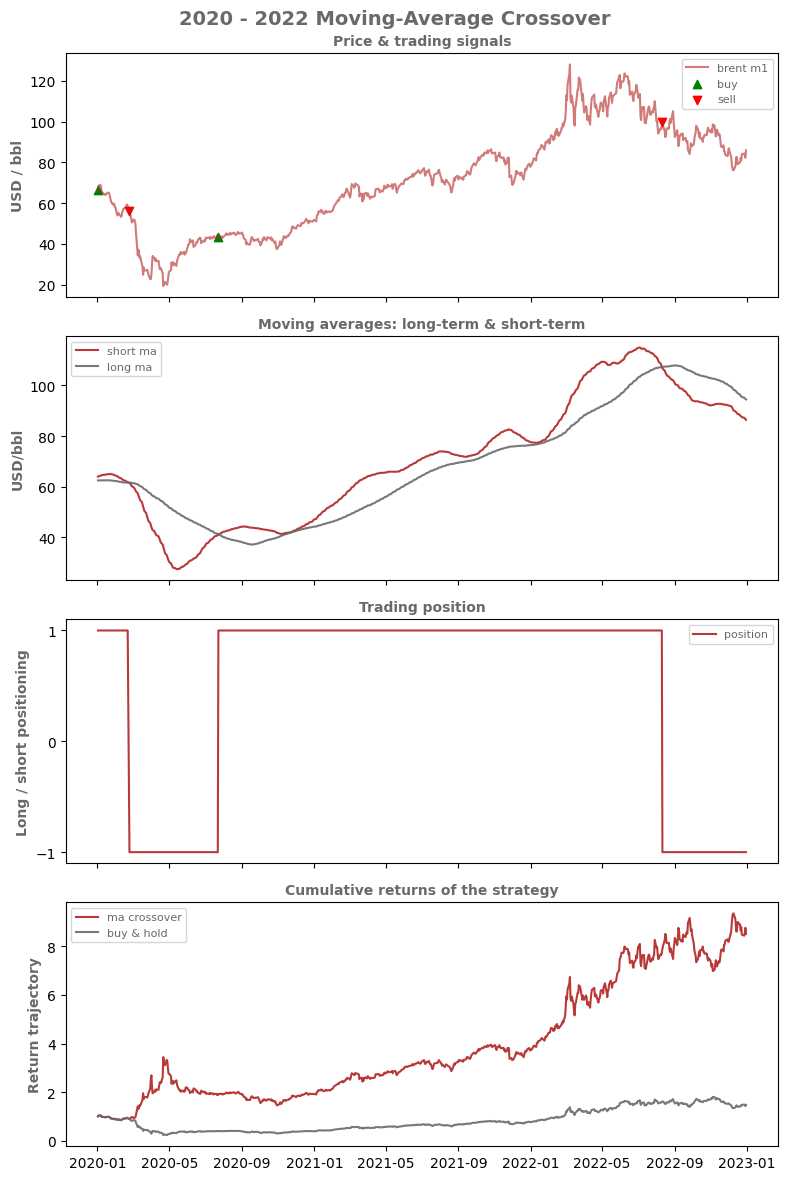

In [ ]:
ma_tester.plot_summary()

Let's go beyond arbitrarly chosen period and have a look at results of several randomly selected years

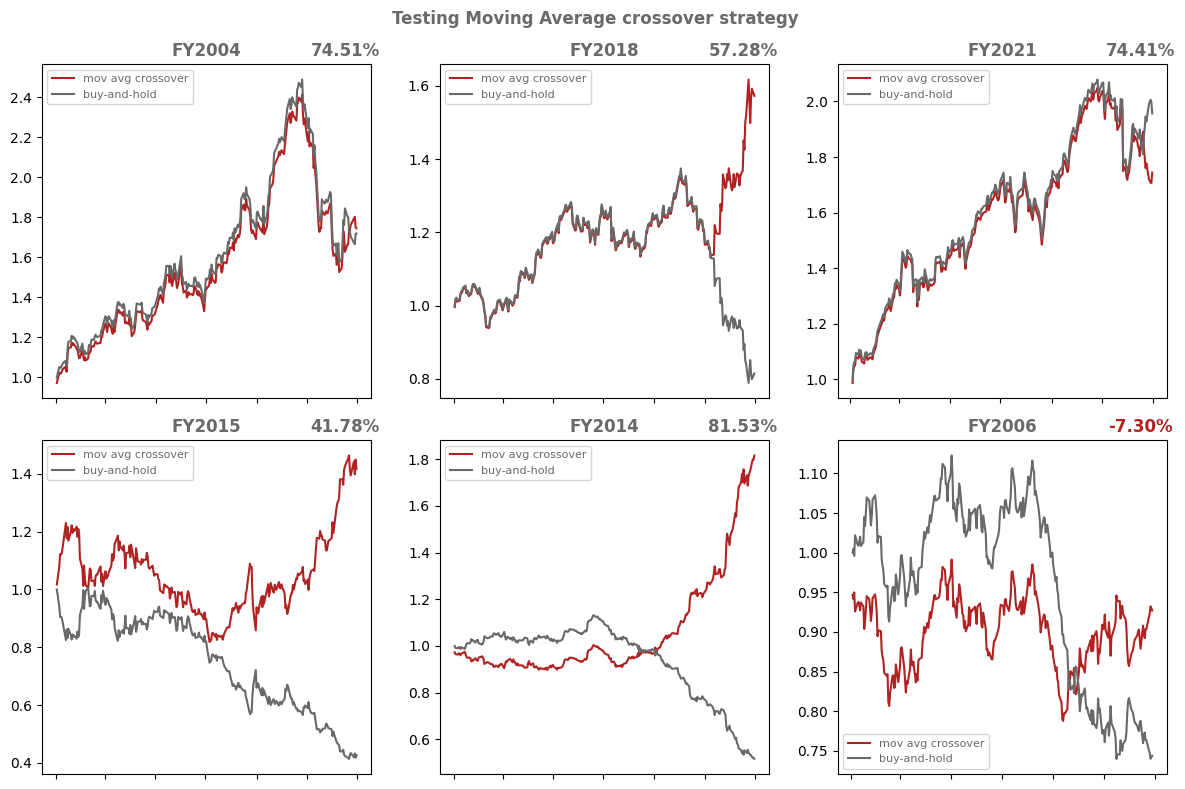

In [ ]:
fig, axes = plt.subplots(nrows = 2, ncols = 3, figsize=(12,8), dpi=100)
fig.suptitle("Testing Moving Average crossover strategy", fontsize=12, fontweight="bold", color = 'dimgray', y=0.98)

year_list = list(np.arange(2004,2022))
year_sample = random.sample(year_list,len(axes.ravel()))

for year_choice, ax in zip(year_sample,axes.ravel()):
  start_point, end_point = str(year_choice) + '-01-01', str(year_choice) + '-12-31'
  ma_tester = ma_crossover(20,138,start_point, end_point)
  ma_tester.plot_results(ax)
plt.tight_layout()

Moving average crosoover strategy clearly outperforms buy-and-hold in a bear market. It does particularly well when a long-term trend is established. Its outperformance clearly is not consistent though. I would not put my money into it...

# **Contrarian**

In simple terms contrarian strategy is based on a premise of a mean-reversion process. If in a chosen window price drops were observed then price rise is expected and consequently the other way around as well.

In [ ]:
class contrarian(trading_strategy):
  ''' Class for testing simple contrarian strategy
  '''
  def __init__(self, window, start, end, cost = cost_value, baseline = True):
    '''
    Additional parameters:
    -----------------
    window: int
        lenght of window to calculate respective mean
    '''
    super().__init__(start, end, cost) # inheriting 3 arguments from mother-class of trading strategy
    self.window = window
    self.baseline = baseline
    self.outcome = None
    self.excesss_return = 0

  def __repr__(self):
    return f'Object designed to test simple contrarian strategy from {self.start} till {self.end}'

  def prepare_data(self):
    df = self.data.copy()
    df['window_return'] = np.log(df['brent_m1'] / df['brent_m1'].shift(1)).rolling(self.window).mean()
    df["position"] = -np.sign(df['window_return'])

    conditions = [(df["position"] - df['position'].shift(1)) == 2,
                  (df["position"] - df['position'].shift(1)) == -2,
                  ((df["position"] - df['position'].shift(1)) == 0) & (df['expiry_day']==False),
                  ((df["position"] - df['position'].shift(1)) == 0) & (df['expiry_day']==True)]
    values = ['go_long','go_short', 'hold', 'roll']
    df['action'] = np.select(conditions, values, default = 'hold')
    df['trades'] = df['position'].diff().fillna(0).abs().astype('int32')
    df.loc[df['action'] == 'roll','trades'] = 2
    df['costs'] = df['trades'] * self.cost

    conditions = [(df['expiry_day']== False) & (df['action'] == 'go_short'),
                  (df['expiry_day']== True) & (df['action'] == 'go_short'),
                  (df['expiry_day']== False) & (df['action'] == 'go_long'),
                  (df['expiry_day']== True) & (df['action'] == 'go_long'),
                  (df['position']== 1) & (df['action'] == 'roll'),
                  (df['position']== -1) & (df['action'] == 'roll')]
    values = [df['brent_bid_m1'], (df['brent_bid_m1']+df['brent_bid_m2'])/2,
              df['brent_ask_m1'], (df['brent_ask_m1']+df['brent_ask_m2'])/2,
              (df['brent_bid_m1']+df['brent_ask_m2'])/2,
              (df['brent_ask_m1']+df['brent_bid_m2'])/2]
    df['price'] = np.select(conditions, values, default = df['brent_m1'])
    df = df.dropna()
    df['buy_signal'] = np.where(df['action']=='go_long',df['price'],np.nan)
    df['sell_signal'] = np.where(df['action']=='go_short',df['price'],np.nan)

    if self.baseline == True:
      conditions = [df.index == df.index[df.index.get_indexer([self.start], method = 'bfill')[0]],
                  df.index == df.index[df.index.get_indexer([self.end], method = 'ffill')[0]],
                  (df.index > self.start) & (df.index < self.end) & (df['expiry_day'] == True)]
      values = ['buy', 'sell', 'roll']
      df['base_action'] = np.select(conditions, values, default='hold')
      df['base_position'] = 0
      df.iloc[df.index.get_indexer([self.start], method = 'bfill')[0] : df.index.get_indexer([self.end], method = 'ffill')[0], df.columns.get_loc("base_position")] = 1
      df['base_trades'] = df['base_position'].diff().fillna(0).abs().astype('int32')
      df.loc[df['base_action'] == 'roll','base_trades'] = 2
      df['base_costs'] = df['base_trades'] * self.cost
      conditions = [(df['expiry_day']== False) & (df['base_action'] == 'buy'),
                    (df['expiry_day']== True) & (df['base_action'] == 'buy'),
                    (df['expiry_day']== False) & (df['base_action'] == 'sell'),
                    (df['expiry_day']== True) & (df['base_action'] == 'sell'),
                    (df['expiry_day']== False) & (df['base_action'] == 'hold'),
                    (df['expiry_day']== True) & (df['base_action'] == 'roll')]
      values = [df['brent_ask_m1'], df['brent_ask_m2'],
                df['brent_bid_m1'], df['brent_bid_m1'],
                df['brent_m1'], (df['brent_bid_m1']+df['brent_ask_m2'])/2]
      df['base_price'] = np.select(conditions, values, default = df['brent_m1'])
    self.full_data = df.iloc[df.index.get_indexer([self.start], method = 'bfill')[0]-1 : df.index.get_indexer([self.end], method = 'ffill')[0]+1].copy()

  def change_window(self, new_window = None):
    ''' Modifies settings regarding lenght of respective window
    '''
    if new_window is not None:
      self.window = new_window
    self.prepare_data()

  def test_strategy(self):
    ''' Performs a backtest of the contrarian strategy for a given period
    '''
    if self.full_data is None:
      self.prepare_data()
    df = self.full_data.copy()

    conditions = [(df['expiry_day']== False) & (df['action'] == 'go_short'),
                  (df['expiry_day'].shift(1)== False) & (df['action'].shift(1) == 'go_short'),
                  (df['expiry_day']== True) & (df['action'] == 'go_short'),
                  (df['expiry_day'].shift(1)== True) & (df['action'].shift(1) == 'go_short'),
                  (df['expiry_day']== False) & (df['action'] == 'go_long'),
                  (df['expiry_day'].shift(1)== False) & (df['action'].shift(1) == 'go_long'),
                  (df['expiry_day']== True) & (df['action'] == 'go_long'),
                  (df['expiry_day'].shift(1)== True) & (df['action'].shift(1) == 'go_long'),
                  (df['position'] == 1) & (df['action'] == 'roll'),
                  (df['position'].shift(1) == 1) & (df['action'].shift(1) == 'roll'),
                  (df['position'] == -1) & (df['action'] == 'roll'),
                  (df['position'].shift(1) == -1) & (df['action'].shift(1) == 'roll')]
    values = [np.log((df['brent_bid_m1'] - self.cost)/(df['price'].shift(1))),
              np.log(df['price']/(df['brent_bid_m1'].shift(1)-self.cost)),
              np.log((df['brent_bid_m2'] - self.cost)/(df['price'].shift(1))),
              np.log(df['price']/(df['brent_bid_m2'].shift(1)-self.cost)),
              np.log((df['brent_ask_m1'] + self.cost)/(df['price'].shift(1))),
              np.log(df['price']/(df['brent_ask_m1'].shift(1)+self.cost)),
              np.log((df['brent_ask_m2'] + self.cost)/(df['price'].shift(1))),
              np.log(df['price']/(df['brent_ask_m2'].shift(1)+self.cost)),
              np.log((df['brent_bid_m1'] + ((df['brent_bid_m1']-self.cost)-(df['brent_ask_m2']+self.cost))) / (df['price'].shift(1))),
              np.log(df['price']/(df['brent_ask_m2'].shift(1)+self.cost)),
              np.log((df['brent_ask_m1'] + ((df['brent_ask_m1']+self.cost)-(df['brent_bid_m2']-self.cost))) / (df['price'].shift(1))),
              np.log(df['price']/(df['brent_bid_m2'].shift(1)-self.cost))]
    df['returns'] = np.select(conditions, values, default = np.log(df['price']/df['price'].shift(1)))
    df['returns'] = df['position'].shift(1) * df['returns']
    df["cum_returns"] = df["returns"].cumsum().apply(np.exp)
    self.full_data = df
    outcome = (df.iloc[df.index.get_indexer([self.end], method = 'ffill')[0], df.columns.get_loc("cum_returns")]-1)*100
    self.outcome = outcome

    if self.baseline == True:
      conditions = [df['base_action'].shift(1) == 'buy',
                  df['base_action'] == 'roll',
                  (df['base_action'].shift(1) == 'roll') & (df['base_action'] == 'hold'),
                  df['base_action'] == 'sell']
      values = [np.log(df['base_price']/(df['base_price'].shift(1)+self.cost)),
                np.log((2*df['brent_bid_m1']-df['brent_ask_m2']-self.cost) / df['brent_m1'].shift(1)),
                np.log(df['brent_m1'] / (df['brent_ask_m2'].shift(1)+self.cost)),
                np.log((df['base_price'] - self.cost)/(df['base_price'].shift(1)))]
      df['base_returns'] = np.select(conditions, values, default = np.log(df['base_price']/df['base_price'].shift(1)))
      df['base_returns'] = df['base_position'].shift(1) * df['base_returns']
      df["base_cum_returns"] = df["base_returns"].cumsum().apply(np.exp)
      base_outcome = (df.iloc[df.index.get_indexer([self.end], method = 'ffill')[0], df.columns.get_loc("base_cum_returns")]-1)*100
      excess_return = outcome - base_outcome

    self.full_data = df.loc[self.start : self.end].copy()
    self.results = True
    return round(outcome,4), round(excess_return,4)

  def plot_results(self, axis):
    ''' Plots the results of the contrarian strategy
    '''
    if self.results == False:
      self.test_strategy()
    if self.outcome >=0:
      result_color = 'dimgray'
    else:
      result_color = 'firebrick'

    axis.plot(self.full_data['cum_returns'], color='firebrick', label = 'contrarian')
    if self.baseline == True:
      axis.plot(self.full_data['base_cum_returns'], color='dimgray', label = 'buy-and-hold')
    axis.set_title(f'FY{self.start[:4]}', fontsize = 12, fontweight="bold", color = 'dimgray')
    axis.set_xticklabels([])
    axis.legend(loc='best', fontsize = 8, labelcolor='dimgray')
    axis.annotate(f'{self.outcome:.2f}%', xy=(0.92, 1.04), xycoords="axes fraction", size = 12, fontweight="bold", color = result_color, va="center", ha="center", alpha = 1);

  def plot_summary(self):
    ''' Plots key charts summarizing the strategy
    '''
    if self.full_data is None:
      print(f'Method prepare_data() must be run in the first place')
    else:
      fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(8,12), dpi=100)
      fig.suptitle(f'{self.start[:4]} - {self.end[:4]} Contrarian', fontsize = 14, fontweight="bold", color = 'dimgray')

      ax[0].plot(self.full_data['brent_m1'], color = 'firebrick', label = 'Brent M1', alpha = 0.6)
      ax[0].scatter(self.full_data.index, self.full_data['buy_signal'], label = 'buy', marker = '^', alpha = 1, color = 'green')
      ax[0].scatter(self.full_data.index, self.full_data['sell_signal'], label = 'sell', marker = 'v', alpha = 1, color = 'red')
      ax[0].set_title('Price & trading signals', fontsize = 10, fontweight="bold", color = 'dimgray')
      ax[0].set_ylabel(ylabel='USD / bbl',fontsize = 10, color = 'dimgrey', weight = 'bold')
      ax[0].set_xticklabels([])
      ax[0].legend(loc='best', fontsize = 8, labelcolor='dimgray')

      ax[1].plot(self.full_data['window_return'], color = 'firebrick', label = 'short ma', alpha = 0.9)
      ax[1].set_title('Window return', fontsize = 10, fontweight="bold", color = 'dimgray')
      ax[1].set_ylabel(ylabel='USD/bbl',fontsize = 10, color = 'dimgrey', weight = 'bold')
      ax[1].set_xticklabels([])
      ax[1].legend(loc='best',fontsize = 8, labelcolor='dimgray')

      ax[2].plot(self.full_data['position'], color = 'firebrick', label = 'position', alpha = 0.9)
      ax[2].set_title('Trading position', fontsize = 10, fontweight="bold", color = 'dimgray')
      ax[2].set_ylabel(ylabel='Long / short positioning',fontsize = 10, color = 'dimgrey', weight = 'bold')
      ax[2].set_yticks([-1, 0, 1])
      ax[2].set_xticklabels([])
      ax[2].legend(loc='best',fontsize = 8, labelcolor='dimgray')

      ax[3].plot(self.full_data['cum_returns'], color = 'firebrick', label = 'contrarian', alpha = 0.9)
      ax[3].set_title('Cumulative returns of the strategy', fontsize = 10, fontweight="bold", color = 'dimgray')
      ax[3].set_ylabel(ylabel='Return trajectory',fontsize = 10, color = 'dimgrey', weight = 'bold')
      if self.baseline == True:
        ax[3].plot(self.full_data['base_cum_returns'], color = 'dimgray', label = 'buy & hold', alpha = 0.9)
      ax[3].legend(loc='best',fontsize = 8, labelcolor='dimgray')

      plt.tight_layout()
      plt.savefig('CONTRARIAN')

  def optimize_window(self, window_options):
    '''Searches for optimum window size for a given period
    Parameters:
    ===========
    window_options: list
      list of integers representing window size
    '''
    results = []
    for w in window_options:
      self.change_window(w)
      results.append(self.test_strategy())

    abs, rel = map(list,zip(*results))
    best_result = np.max(abs)
    best_window = window_options[np.argmax(abs)]

    self.change_window(best_window)
    self.test_strategy()

    summary = pd.DataFrame(data = window_options, columns = ['window_size'])
    summary = summary.assign(abs_res = abs)
    summary = summary.assign(rel_res = rel)
    self.summary = summary.copy(deep = False)

    return best_result, best_window


Let's instantiate the strategy...

In [ ]:
cont_tester = contrarian(5, '2020-01-01','2022-12-31')
cont_tester

Object designed to test simple contrarian strategy from 2020-01-01 till 2022-12-31

In [ ]:
cont_tester.data

,brent_m1,brent_bid_m1,brent_ask_m1,brent_m2,brent_bid_m2,brent_ask_m2,expiry_day,volume
date,,,,,,,,
2002-12-30,29.28,29.275,29.285,28.33,28.320,28.340,False,23037
2003-01-02,29.43,29.425,29.435,28.48,28.470,28.490,False,20943
2003-01-03,30.77,30.760,30.780,29.59,29.575,29.605,False,23163
2003-01-06,30.20,30.165,30.235,28.92,28.880,28.960,False,32675
2003-01-07,29.33,29.290,29.370,28.37,28.325,28.415,False,40642
...,...,...,...,...,...,...,...,...
2023-07-25,83.64,83.640,83.640,100.47,100.470,100.470,False,311655
2023-07-26,82.92,82.920,82.920,101.47,101.470,101.470,False,333939
2023-07-27,84.24,84.240,84.240,102.47,102.470,102.470,False,354644


In [ ]:
cont_tester.prepare_data()
cont_tester.full_data

,brent_m1,brent_bid_m1,brent_ask_m1,brent_m2,brent_bid_m2,brent_ask_m2,expiry_day,volume,window_return,position,...,trades,costs,price,buy_signal,sell_signal,base_action,base_position,base_trades,base_costs,base_price
date,,,,,,,,,,,,,,,,,,,,,
2019-12-31,66.00,65.995,66.005,65.29,65.280,65.300,False,54805,-0.001178,1.0,...,2,0.02,66.005,66.005,NaN,hold,0,0,0.00,66.000
2020-01-02,66.25,66.190,66.310,65.56,65.495,65.625,False,81185,-0.002848,1.0,...,0,0.00,66.250,NaN,NaN,buy,1,1,0.01,66.310
2020-01-03,68.60,68.590,68.610,67.76,67.745,67.775,False,202661,0.001992,-1.0,...,2,0.02,68.590,NaN,68.59,hold,1,0,0.00,68.600
2020-01-06,68.91,68.890,68.930,68.07,68.045,68.095,False,152513,0.002189,-1.0,...,0,0.00,68.910,NaN,NaN,hold,1,0,0.00,68.910
2020-01-07,68.27,68.260,68.280,67.57,67.555,67.585,False,142789,-0.000497,1.0,...,2,0.02,68.280,68.280,NaN,hold,1,0,0.00,68.270
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-23,83.92,83.910,83.930,84.50,84.490,84.510,False,180396,0.011982,-1.0,...,2,0.02,83.910,NaN,83.91,hold,1,0,0.00,83.920
2022-12-27,84.33,84.275,84.385,84.68,84.635,84.725,False,160090,0.011043,-1.0,...,0,0.00,84.330,NaN,NaN,hold,1,0,0.00,84.330
2022-12-28,83.26,83.140,83.380,83.99,83.900,84.080,False,211211,0.008013,-1.0,...,0,0.00,83.260,NaN,NaN,hold,1,0,0.00,83.260


Once the data is being prepared properly we are ready to test the strategy

In [ ]:
cont_tester.test_strategy()

(-81.7849, -129.6441)

In [ ]:
cont_tester.optimize_window(list(np.arange(1,25)))

(-7.5621, 15)

The results are mediocre to say the least. Let's check on TOP 10

In [ ]:
cont_tester.summary.nlargest(10,'abs_res')

,window_size,abs_res,rel_res
14,15,-7.5621,-55.4213
12,13,-46.3051,-94.1643
13,14,-55.9034,-103.7626
7,8,-62.3583,-110.2175
5,6,-63.6693,-111.5285
9,10,-64.0502,-111.9094
10,11,-64.1047,-111.9639
11,12,-67.2173,-115.0765
21,22,-74.8568,-122.7160
8,9,-76.1202,-123.9795


In [ ]:
cont_tester.change_window(15)
cont_tester.test_strategy()

(-7.5621, -55.4213)

It's always worth to have a look at the results...

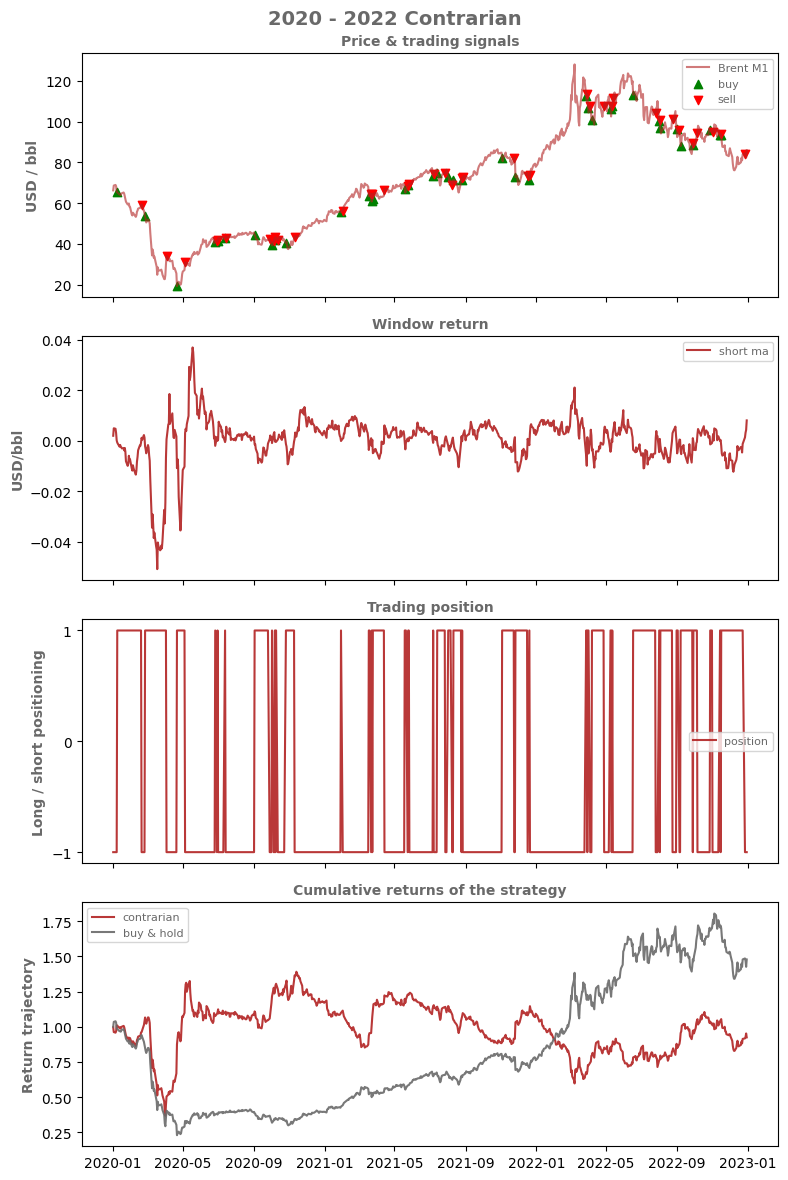

In [ ]:
cont_tester.plot_summary()

We are dealing with quite heavy trading here which generates trading costs but does not bring added-value or extra return. Let's check on the performance of randomly selected annual periods

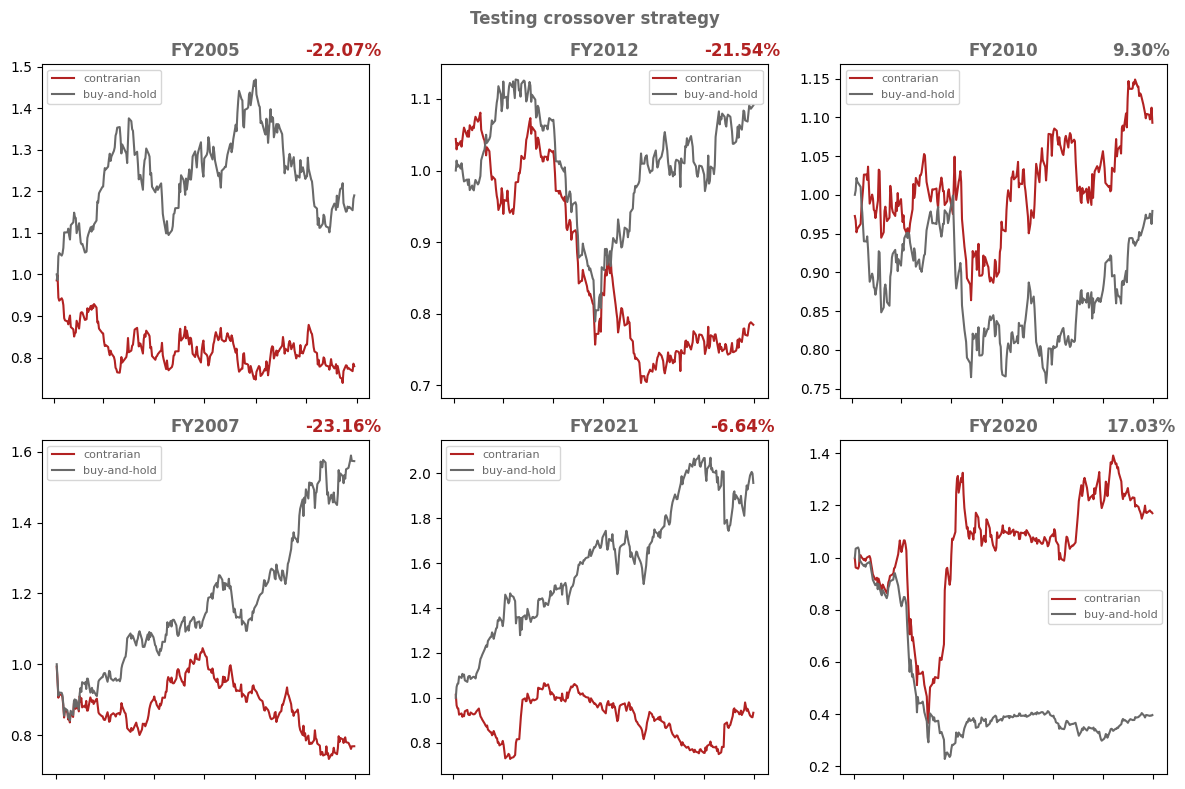

In [ ]:
fig, axes = plt.subplots(nrows = 2, ncols = 3, figsize=(12,8), dpi=100)
fig.suptitle("Testing crossover strategy", fontsize=12, fontweight="bold", color = 'dimgray', y=0.98)

year_list = list(np.arange(2004,2022))
year_sample = random.sample(year_list,len(axes.ravel()))

for year_choice, ax in zip(year_sample,axes.ravel()):
  start_point, end_point = str(year_choice) + '-01-01', str(year_choice) + '-12-31'
  cont_tester = contrarian(15,start_point, end_point)
  cont_tester.plot_results(ax)
plt.tight_layout()

That one does not convince me either

# **BB Mean Reversion**

The concept of Boolinger Bands Mean Reversions comes down to:

1.   creating a price bands (moving average +/- some multiple of standard deviation)
2.   using the above to decipher trading signals:

>*   BUY => when price crosses lower band from the upper side
>*   SELL => when the price crosses upper band from the lower side
>*   NEUTRAL => when price crosses moving average (in the middle of the bands)

In [ ]:
class bb_mean_reversion(trading_strategy):
  ''' Class for testing boolinger-bands mean reversion strategy
  '''
  def __init__(self, window, delta, start, end, cost = cost_value, baseline = True):
    '''
    Additional parameters:
    ----------------------
    window: int
        lenght of window to calculate simple moving average
    delta: float
        spread between moving average and lower / upper bands expressed in multiples of standard deviation units
    '''
    super().__init__(start, end, cost) # inheriting 3 arguments from mother-class of trading strategy
    self.window = window
    self.delta = delta
    self.baseline = baseline
    self.outcome = None
    self.excesss_return = 0

  def __repr__(self):
    return f'Object designed to test boolinger-bands mean reversion strategy from {self.start} till {self.end}'

  def prepare_data(self):
    df = self.data.copy()
    df['moving_average'] = df['brent_m1'].rolling(self.window).mean()
    df = df.dropna()
    df['low_band'] = df['moving_average'] - (df['brent_m1'].rolling(self.window).std() * self.delta)
    df['high_band'] = df['moving_average'] + (df['brent_m1'].rolling(self.window).std() * self.delta)
    df['spread'] = df['brent_m1'] - df['moving_average']
    conditions = [df['brent_m1'] < df['low_band'],
                  df['brent_m1'] > df['high_band'],
                  df['spread']*df['spread'].shift(1)<0]
    values = [1, -1, 0]
    df['position'] = np.select(conditions, values, default = np.nan)
    df['position'] = df['position'].ffill().fillna(0)

    conditions = [(df['position'].shift(1) < 1) & (df['position'] == 1),
                  (df['position'].shift(1) > -1) & (df['position'] == -1),
                  (df['position'].shift(1) != 0) & (df['position'] == 0),
                  (df['position'].shift(1) == df['position']) & (df['position'] != 0) & (df['expiry_day']==True)]
    values = ['go_long' ,'go_short', 'go_neutral', 'roll']
    df['action'] = np.select(conditions, values, default = 'hold')
    df['trades'] = df['position'].diff().fillna(0).abs().astype('int32')
    df.loc[df['action'] == 'roll','trades'] = 2
    df['costs'] = df['trades'] * self.cost

    conditions = [(df['expiry_day']== False) & (df['action'] == 'go_short'),
                  (df['expiry_day']== True) & (df['action'] == 'go_short'),
                  (df['expiry_day']== False) & (df['action'] == 'go_long'),
                  (df['expiry_day']== True) & (df['action'] == 'go_long'),
                  (df['position'].shift(1 )== 1) & (df['action'] == 'go_neutral'),
                  (df['position'].shift(1) == -1) & (df['action'] == 'go_neutral'),
                  (df['position']== 1) & (df['action'] == 'roll'),
                  (df['position'] == -1) & (df['action'] == 'roll')]
    values = [df['brent_bid_m1'], df['brent_bid_m2'],
              df['brent_ask_m1'], df['brent_ask_m2'],
              df['brent_bid_m1'], df['brent_ask_m1'],
              (df['brent_bid_m1']+df['brent_ask_m2'])/2,
              (df['brent_ask_m1']+df['brent_bid_m2'])/2]
    df['price'] = np.select(conditions, values, default = df['brent_m1'])
    df['buy_signal'] = np.where(df['action']=='go_long',df['price'],np.nan)
    df['sell_signal'] = np.where(df['action']=='go_short',df['price'],np.nan)
    df['neutral_signal'] = np.where(df['action']=='go_neutral',df['price'],np.nan)

    if self.baseline == True:
      conditions = [df.index == df.index[df.index.get_indexer([self.start], method = 'bfill')[0]],
                  df.index == df.index[df.index.get_indexer([self.end], method = 'ffill')[0]],
                  (df.index > self.start) & (df.index < self.end) & (df['expiry_day'] == True)]
      values = ['buy', 'sell', 'roll']
      df['base_action'] = np.select(conditions, values, default='hold')
      df['base_position'] = 0
      df.iloc[df.index.get_indexer([self.start], method = 'bfill')[0] : df.index.get_indexer([self.end], method = 'ffill')[0], df.columns.get_loc("base_position")] = 1
      df['base_trades'] = df['base_position'].diff().fillna(0).abs().astype('int32')
      df.loc[df['base_action'] == 'roll','base_trades'] = 2
      df['base_costs'] = df['base_trades'] * self.cost
      conditions = [(df['expiry_day']== False) & (df['base_action'] == 'buy'),
                    (df['expiry_day']== True) & (df['base_action'] == 'buy'),
                    (df['expiry_day']== False) & (df['base_action'] == 'sell'),
                    (df['expiry_day']== True) & (df['base_action'] == 'sell'),
                    (df['expiry_day']== False) & (df['base_action'] == 'hold'),
                    (df['expiry_day']== True) & (df['base_action'] == 'roll')]
      values = [df['brent_ask_m1'], df['brent_ask_m2'],
                df['brent_bid_m1'], df['brent_bid_m1'],
                df['brent_m1'], (df['brent_bid_m1']+df['brent_ask_m2'])/2]
      df['base_price'] = np.select(conditions, values, default = df['brent_m1'])
    self.full_data = df.iloc[df.index.get_indexer([self.start], method = 'bfill')[0]-1 : df.index.get_indexer([self.end], method = 'ffill')[0]+1].copy()

  def set_params(self, new_window = None, new_delta = None):
    ''' Modifies settings regarding the combination of window and delta
    '''
    if new_window is not None:
      self.window = new_window
    if new_delta is not None:
      self.delta = new_delta
    self.prepare_data()

  def test_strategy(self):
    ''' Performs a backtest of the bb mean reversion strategy for a given period
    '''
    if self.full_data is None:
      self.prepare_data()
    df = self.full_data.copy()

    conditions = [(df['expiry_day']== False) & (df['action'] == 'go_short'),
                  (df['expiry_day'].shift(1)== False) & (df['action'].shift(1) == 'go_short'),
                  (df['expiry_day']== True) & (df['action'] == 'go_short'),
                  (df['expiry_day'].shift(1)== True) & (df['action'].shift(1) == 'go_short'),
                  (df['expiry_day']== False) & (df['action'] == 'go_long'),
                  (df['expiry_day'].shift(1)== False) & (df['action'].shift(1) == 'go_long'),
                  (df['expiry_day']== True) & (df['action'] == 'go_long'),
                  (df['expiry_day'].shift(1)== True) & (df['action'].shift(1) == 'go_long'),
                  (df['position'].shift(1 )== 1) & (df['action'] == 'go_neutral'),
                  (df['position'].shift(1) == -1) & (df['action'] == 'go_neutral'),
                  (df['position'] == 1) & (df['action'] == 'roll'),
                  (df['position'].shift(1) == 1) & (df['action'].shift(1) == 'roll'),
                  (df['position'] == -1) & (df['action'] == 'roll'),
                  (df['position'].shift(1) == -1) & (df['action'].shift(1) == 'roll')
                  ]
    values = [np.log((df['brent_bid_m1'] - self.cost)/(df['price'].shift(1))),
              np.log(df['price']/(df['brent_bid_m1'].shift(1)-self.cost)),
              np.log((df['brent_bid_m2'] - self.cost)/(df['price'].shift(1))),
              np.log(df['price']/(df['brent_bid_m2'].shift(1)-self.cost)),
              np.log((df['brent_ask_m1'] + self.cost)/(df['price'].shift(1))),
              np.log(df['price']/(df['brent_ask_m1'].shift(1)+self.cost)),
              np.log((df['brent_ask_m2'] + self.cost)/(df['price'].shift(1))),
              np.log(df['price']/(df['brent_ask_m2'].shift(1)+self.cost)),
              np.log((df['brent_bid_m1'] - self.cost)/(df['price'].shift(1))),
              np.log((df['brent_ask_m1'] + self.cost)/(df['price'].shift(1))),
              np.log((df['brent_bid_m1'] + ((df['brent_bid_m1']-self.cost)-(df['brent_ask_m2']+self.cost))) / (df['price'].shift(1))),
              np.log(df['price']/(df['brent_ask_m2'].shift(1)+self.cost)),
              np.log((df['brent_ask_m1'] + ((df['brent_ask_m1']+self.cost)-(df['brent_bid_m2']-self.cost))) / (df['price'].shift(1))),
              np.log(df['price']/(df['brent_bid_m2'].shift(1)-self.cost))
              ]
    df['returns'] = np.select(conditions, values, default = np.log(df['price']/df['price'].shift(1)))
    df['returns'] = df['position'].shift(1) * df['returns']
    df["cum_returns"] = df["returns"].cumsum().apply(np.exp)
    outcome = (df.iloc[df.index.get_indexer([self.end], method = 'ffill')[0], df.columns.get_loc("cum_returns")]-1)*100
    self.outcome = outcome
    self.full_data = df.loc[self.start : self.end].copy()

    if self.baseline == True:
      conditions = [df['base_action'].shift(1) == 'buy',
                  df['base_action'] == 'roll',
                  (df['base_action'].shift(1) == 'roll') & (df['base_action'] == 'hold'),
                  df['base_action'] == 'sell']
      values = [np.log(df['base_price']/(df['base_price'].shift(1)+self.cost)),
                np.log((2*df['brent_bid_m1']-df['brent_ask_m2']-self.cost) / df['brent_m1'].shift(1)),
                np.log(df['brent_m1'] / (df['brent_ask_m2'].shift(1)+self.cost)),
                np.log((df['base_price'] - self.cost)/(df['base_price'].shift(1)))]
      df['base_returns'] = np.select(conditions, values, default = np.log(df['base_price']/df['base_price'].shift(1)))
      df['base_returns'] = df['base_position'].shift(1) * df['base_returns']
      df["base_cum_returns"] = df["base_returns"].cumsum().apply(np.exp)
      base_outcome = (df.iloc[df.index.get_indexer([self.end], method = 'ffill')[0], df.columns.get_loc("base_cum_returns")]-1)*100
      excess_return = outcome - base_outcome
    self.full_data = df.loc[self.start : self.end].copy()
    self.results = True
    return round(outcome,4), round(excess_return,4)

  def plot_results(self, axis):
    ''' Plots the results of the bb mean reversion strategy
    '''
    if self.results == False:
      self.test_strategy()
    if self.outcome >=0:
      result_color = 'dimgray'
    else:
      result_color = 'firebrick'

    axis.plot(self.full_data['cum_returns'], color='firebrick', label = 'bb mean rev')
    if self.baseline == True:
      axis.plot(self.full_data['base_cum_returns'], color='dimgray', label = 'buy-and-hold')
    axis.set_title(f'FY{self.start[:4]}', fontsize = 12, fontweight="bold", color = 'dimgray')
    axis.set_xticklabels([])
    axis.legend(loc='best', fontsize = 8, labelcolor='dimgray')
    axis.annotate(f'{self.outcome:.2f}%', xy=(0.92, 1.04), xycoords="axes fraction", size = 12, fontweight="bold", color = result_color, va="center", ha="center", alpha = 1);

  def plot_summary(self):
    ''' Plots key charts summarizing the strategy
    '''
    if self.full_data is None:
      print(f'Method prepare_data() must be run in the first place')
    else:
      fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(8,12), dpi=100)
      fig.suptitle(f'{self.start[:4]} - {self.end[:4]} Boolinger-Bands Mean Reversion', fontsize = 14, fontweight="bold", color = 'dimgray')

      ax[0].plot(self.full_data['brent_m1'], color = 'firebrick', label = 'Brent M1', alpha = 0.6)
      ax[0].scatter(self.full_data.index, self.full_data['buy_signal'], label = 'buy', marker = '^', alpha = 1, color = 'green')
      ax[0].scatter(self.full_data.index, self.full_data['sell_signal'], label = 'sell', marker = 'v', alpha = 1, color = 'red')
      ax[0].scatter(self.full_data.index, self.full_data['neutral_signal'], label = 'neutral', marker = 'D', alpha = 1, color = 'black')
      ax[0].set_title('Price & trading signals', fontsize = 10, fontweight="bold", color = 'dimgray')
      ax[0].set_ylabel(ylabel='USD / bbl',fontsize = 10, color = 'dimgrey', weight = 'bold')
      ax[0].set_xticklabels([])
      ax[0].legend(loc='best', fontsize = 8, labelcolor='dimgray')

      ax[1].plot(self.full_data['low_band'], color = 'dimgray', label = 'low band', alpha = 0.9)
      ax[1].plot(self.full_data['high_band'], color = 'dimgrey', label = 'high band', alpha = 0.9)
      ax[1].plot(self.full_data['moving_average'], linestyle='dashed', color = 'dimgrey', label = 'sm avg', alpha = 0.9)
      ax[1].plot(self.full_data['price'], color = 'firebrick', label = 'price', alpha = 1)
      ax[1].set_title('BB upper & lower limits', fontsize = 10, fontweight="bold", color = 'dimgray')
      ax[1].set_ylabel(ylabel='USD/bbl',fontsize = 10, color = 'dimgrey', weight = 'bold')
      ax[1].set_xticklabels([])
      ax[1].legend(loc='best',fontsize = 8, labelcolor='dimgray')

      ax[2].plot(self.full_data['position'], color = 'firebrick', label = 'position', alpha = 0.9)
      ax[2].set_title('Trading position', fontsize = 10, fontweight="bold", color = 'dimgray')
      ax[2].set_ylabel(ylabel='Long / short positioning',fontsize = 10, color = 'dimgrey', weight = 'bold')
      ax[2].set_yticks([-1, 0, 1])
      ax[2].set_xticklabels([])
      ax[2].legend(loc='best',fontsize = 8, labelcolor='dimgray')

      ax[3].plot(self.full_data['cum_returns'], color = 'firebrick', label = 'bb mean reversion', alpha = 0.9)
      ax[3].set_title('Cumulative returns of the strategy', fontsize = 10, fontweight="bold", color = 'dimgray')
      ax[3].set_ylabel(ylabel='Return trajectory',fontsize = 10, color = 'dimgrey', weight = 'bold')
      if self.baseline == True:
        ax[3].plot(self.full_data['base_cum_returns'], color = 'dimgray', label = 'buy & hold', alpha = 0.9)
      ax[3].legend(loc='best',fontsize = 8, labelcolor='dimgray')

      plt.tight_layout()
      plt.savefig('BB_MEAN_REVERSION')

  def optimize_params(self, window_range, delta_range):
    '''Searches for optimum window / delta combination for a given period
    Parameters:
    ===========
    window_range: tuple of integers
      assumes the following form (start, end, step)
    delta_range: tuple of floats
      assumes the following form (start, end, step)
    '''
    pairs = list(product(range(*window_range), np.arange(*delta_range)))

    results = []
    for pair in pairs:
      self.set_params(pair[0], pair[1])
      results.append(self.test_strategy())

    abs, rel = map(list,zip(*results))
    best_result = np.max(abs)
    best_pair = pairs[np.argmax(abs)]

    self.set_params(best_pair[0], best_pair[1])
    self.test_strategy()

    summary = pd.DataFrame(data = pairs, columns = ['window_choice', 'delta_choice'])
    summary = summary.assign(abs_res = abs)
    summary = summary.assign(rel_res = rel)
    self.summary = summary.copy(deep = False)

    return best_result, best_pair

Lets test the above code with: 22-day simple moving average & 2 standard deviations to start with

In [ ]:
bb_tester = bb_mean_reversion(22, 2, '2020-01-01','2022-12-31')
bb_tester

Object designed to test boolinger-bands mean reversion strategy from 2020-01-01 till 2022-12-31

In [ ]:
bb_tester.prepare_data()
bb_tester.full_data

,brent_m1,brent_bid_m1,brent_ask_m1,brent_m2,brent_bid_m2,brent_ask_m2,expiry_day,volume,moving_average,low_band,...,costs,price,buy_signal,sell_signal,neutral_signal,base_action,base_position,base_trades,base_costs,base_price
date,,,,,,,,,,,,,,,,,,,,,
2019-12-31,66.00,65.995,66.005,65.29,65.280,65.300,False,54805,65.049091,60.785330,...,0.0,66.00,NaN,NaN,NaN,hold,0,0,0.00,66.000
2020-01-02,66.25,66.190,66.310,65.56,65.495,65.625,False,81185,65.222727,61.097025,...,0.0,66.25,NaN,NaN,NaN,buy,1,1,0.01,66.310
2020-01-03,68.60,68.590,68.610,67.76,67.745,67.775,False,202661,65.571818,61.678627,...,0.0,68.60,NaN,NaN,NaN,hold,1,0,0.00,68.600
2020-01-06,68.91,68.890,68.930,68.07,68.045,68.095,False,152513,65.939545,62.416487,...,0.0,68.91,NaN,NaN,NaN,hold,1,0,0.00,68.910
2020-01-07,68.27,68.260,68.280,67.57,67.555,67.585,False,142789,66.179091,62.779080,...,0.0,68.27,NaN,NaN,NaN,hold,1,0,0.00,68.270
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-23,83.92,83.910,83.930,84.50,84.490,84.510,False,180396,81.501364,75.324062,...,0.0,83.92,NaN,NaN,NaN,hold,1,0,0.00,83.920
2022-12-27,84.33,84.275,84.385,84.68,84.635,84.725,False,160090,81.455455,75.383587,...,0.0,84.33,NaN,NaN,NaN,hold,1,0,0.00,84.330
2022-12-28,83.26,83.140,83.380,83.99,83.900,84.080,False,211211,81.438636,75.390004,...,0.0,83.26,NaN,NaN,NaN,hold,1,0,0.00,83.260


What would be the result?

In [ ]:
bb_tester.test_strategy()

(-47.0748, -94.934)

Let's check best combination

In [ ]:
bb_tester.optimize_params((20,50,2),(1.6,2.5,0.1))

(-31.578, (22, 2.1000000000000005))

and TOP 10 too...

In [ ]:
bb_tester.summary.nlargest(10,'abs_res')

,window_choice,delta_choice,abs_res,rel_res
14,22,2.1,-31.5780,-79.4372
44,28,2.4,-32.6858,-80.5451
34,26,2.3,-35.3215,-83.1808
4,20,2.0,-35.6394,-83.4986
35,26,2.4,-35.9400,-83.7993
15,22,2.2,-36.3643,-84.2235
5,20,2.1,-37.9544,-85.8136
25,24,2.3,-42.2267,-90.0859
6,20,2.2,-42.6238,-90.4830
43,28,2.3,-45.0289,-92.8881


TOP combo results in 75 percentage points above buy-and-hold for that particular year but it's just a peanut above a risk-free rate.

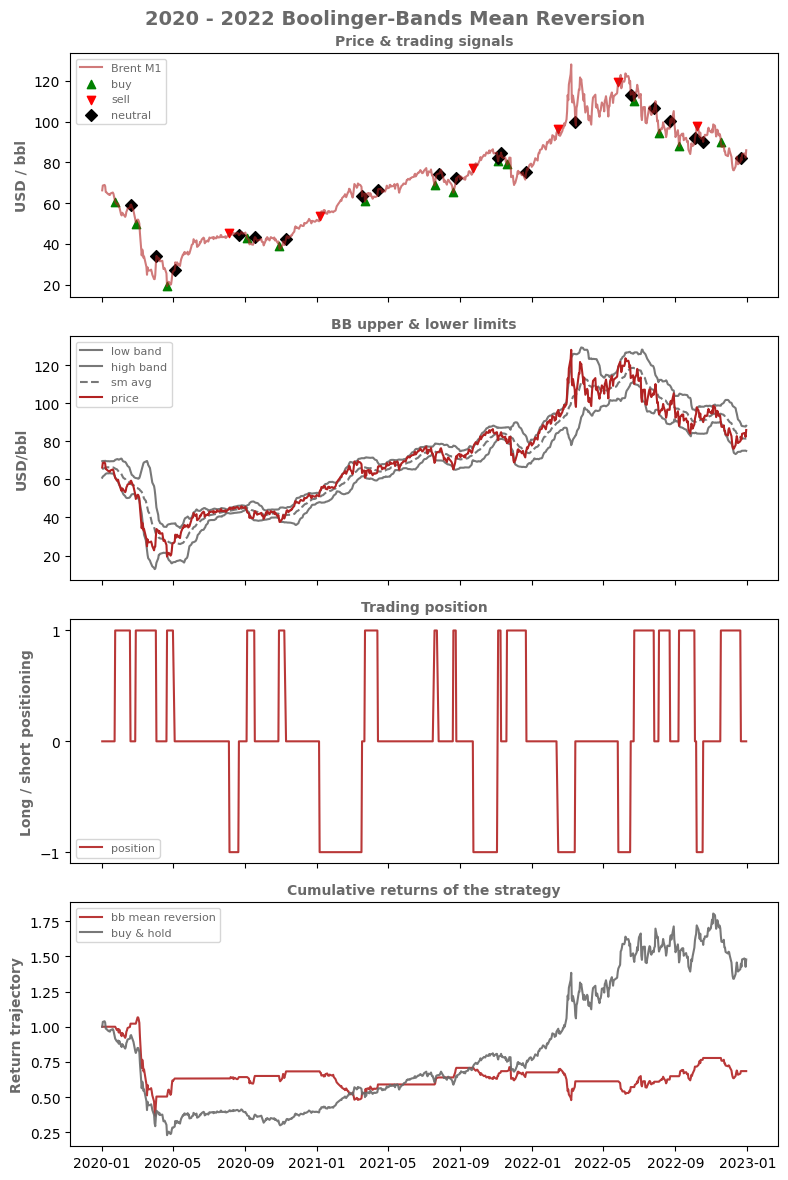

In [ ]:
bb_tester.plot_summary()

What strikes here when compared to the previous strategies is an extended period of (safe) neutral position.

Let's see how the strategy works in randomly selected annual periods.

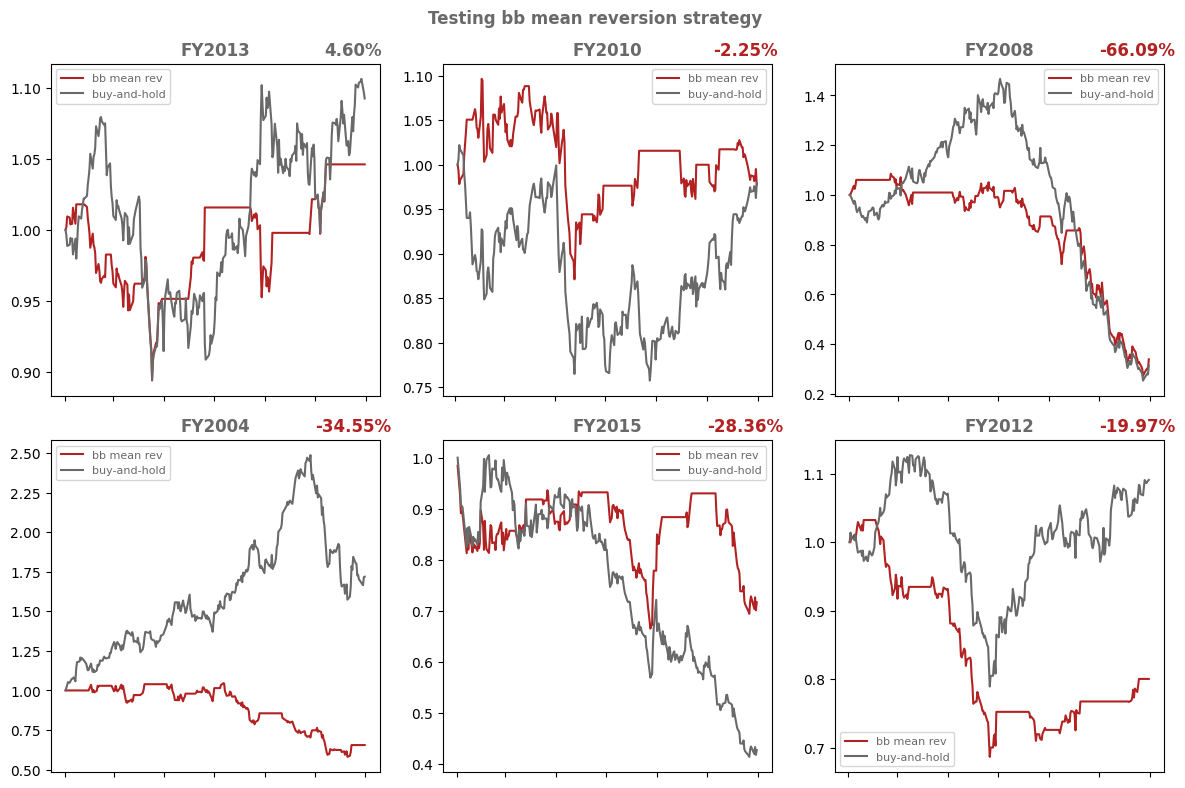

In [ ]:
fig, axes = plt.subplots(nrows = 2, ncols = 3, figsize=(12,8), dpi=100)
fig.suptitle("Testing bb mean reversion strategy", fontsize=12, fontweight="bold", color = 'dimgray', y=0.98)

year_list = list(np.arange(2004,2022))
year_sample = random.sample(year_list,len(axes.ravel()))

for year_choice, ax in zip(year_sample,axes.ravel()):
  start_point, end_point = str(year_choice) + '-01-01', str(year_choice) + '-12-31'
  bb_tester = bb_mean_reversion(20,2,start_point, end_point)
  bb_tester.plot_results(ax)
plt.tight_layout()

In a bear market it does limit losses but overall the results are fairly poor to say the least

# **Ona Balance Volume**

The indicator measures the cumulative trading activity from both angles: buy side & sell side. Buy OBV will get higher on a day when price rallies while sell OBV will rise on a day when price falls. On each day volume is added or subtracted from the marker based on whether the price went higher or lower.

In [ ]:
class on_balance_volume(trading_strategy):
  ''' Class for testing on balance volume strategy
  '''
  def __init__(self, window, start, end, cost = cost_value, baseline = True):
    '''
    Additional parameters:
    ----------------------
    window: int
        lenght of window to calculate OBV exponential moving average
    '''
    super().__init__(start, end, cost) # inheriting 3 arguments from mother-class of trading strategy
    self.window = window
    self.baseline = baseline
    self.outcome = None
    self.excesss_return = 0

  def __repr__(self):
    return f'Object designed to test on blance volume strategy from {self.start} till {self.end}'

  def prepare_data(self):
    df = self.data.copy()
    df = df.iloc[df.index.get_indexer([self.start], method = 'bfill')[0]-1 : df.index.get_indexer([self.end], method = 'ffill')[0]+1].copy()
    df['obv'] = (np.sign(df['brent_m1'].diff()) * df['volume']).fillna(0).cumsum()
    df['obv_ema'] = df['obv'].ewm(span=self.window).mean()

    conditions = [df['obv'] > df['obv_ema'],
                  df['obv'] < df['obv_ema'],
                  df['obv'] == df['obv_ema']]
    values = [1, -1, 0]
    df['position'] = np.select(conditions, values, default = np.nan)
    df['position'] = df['position'].ffill().fillna(0)

    conditions = [(df['position'].shift(1) < 1) & (df['position'] == 1),
                  (df['position'].shift(1) > -1) & (df['position'] == -1),
                  (df['position'].shift(1) != 0) & (df['position'] == 0),
                  (df['position'].shift(1) == df['position']) & (df['position'] != 0) & (df['expiry_day']==True)]
    values = ['go_long' ,'go_short', 'go_neutral', 'roll']
    df['action'] = np.select(conditions, values, default = 'hold')
    df['trades'] = df['position'].diff().fillna(0).abs().astype('int32')
    df.loc[df['action'] == 'roll','trades'] = 2
    df['costs'] = df['trades'] * self.cost

    conditions = [(df['expiry_day']== False) & (df['action'] == 'go_short'),
                  (df['expiry_day']== True) & (df['action'] == 'go_short'),
                  (df['expiry_day']== False) & (df['action'] == 'go_long'),
                  (df['expiry_day']== True) & (df['action'] == 'go_long'),
                  (df['position'].shift(1 )== 1) & (df['action'] == 'go_neutral'),
                  (df['position'].shift(1) == -1) & (df['action'] == 'go_neutral'),
                  (df['position']== 1) & (df['action'] == 'roll'),
                  (df['position'] == -1) & (df['action'] == 'roll')]
    values = [df['brent_bid_m1'], df['brent_bid_m2'],
              df['brent_ask_m1'], df['brent_ask_m2'],
              df['brent_bid_m1'], df['brent_ask_m1'],
              (df['brent_bid_m1']+df['brent_ask_m2'])/2,
              (df['brent_ask_m1']+df['brent_bid_m2'])/2]
    df['price'] = np.select(conditions, values, default = df['brent_m1'])
    df['buy_signal'] = np.where(df['action']=='go_long',df['price'],np.nan)
    df['sell_signal'] = np.where(df['action']=='go_short',df['price'],np.nan)
    df['neutral_signal'] = np.where(df['action']=='go_neutral',df['price'],np.nan)

    if self.baseline == True:
      conditions = [df.index == df.index[df.index.get_indexer([self.start], method = 'bfill')[0]],
                  df.index == df.index[df.index.get_indexer([self.end], method = 'ffill')[0]],
                  (df.index > self.start) & (df.index < self.end) & (df['expiry_day'] == True)]
      values = ['buy', 'sell', 'roll']
      df['base_action'] = np.select(conditions, values, default='hold')
      df['base_position'] = 0
      df.iloc[df.index.get_indexer([self.start], method = 'bfill')[0] : df.index.get_indexer([self.end], method = 'ffill')[0], df.columns.get_loc("base_position")] = 1
      df['base_trades'] = df['base_position'].diff().fillna(0).abs().astype('int32')
      df.loc[df['base_action'] == 'roll','base_trades'] = 2
      df['base_costs'] = df['base_trades'] * self.cost
      conditions = [(df['expiry_day']== False) & (df['base_action'] == 'buy'),
                    (df['expiry_day']== True) & (df['base_action'] == 'buy'),
                    (df['expiry_day']== False) & (df['base_action'] == 'sell'),
                    (df['expiry_day']== True) & (df['base_action'] == 'sell'),
                    (df['expiry_day']== False) & (df['base_action'] == 'hold'),
                    (df['expiry_day']== True) & (df['base_action'] == 'roll')]
      values = [df['brent_ask_m1'], df['brent_ask_m2'],
                df['brent_bid_m1'], df['brent_bid_m1'],
                df['brent_m1'], (df['brent_bid_m1']+df['brent_ask_m2'])/2]
      df['base_price'] = np.select(conditions, values, default = df['brent_m1'])
    self.full_data = df.iloc[df.index.get_indexer([self.start], method = 'bfill')[0]-1 : df.index.get_indexer([self.end], method = 'ffill')[0]+1].copy()

  def set_params(self, new_window = None):
    ''' Modifies settings regarding the length of the window
    '''
    if new_window is not None:
      self.window = new_window
    self.prepare_data()

  def test_strategy(self):
    ''' Performs a backtest of the on balance volume strategy for a given period
    '''
    if self.full_data is None:
      self.prepare_data()
    df = self.full_data.copy()

    conditions = [(df['expiry_day']== False) & (df['action'] == 'go_short'),
                  (df['expiry_day'].shift(1)== False) & (df['action'].shift(1) == 'go_short'),
                  (df['expiry_day']== True) & (df['action'] == 'go_short'),
                  (df['expiry_day'].shift(1)== True) & (df['action'].shift(1) == 'go_short'),
                  (df['expiry_day']== False) & (df['action'] == 'go_long'),
                  (df['expiry_day'].shift(1)== False) & (df['action'].shift(1) == 'go_long'),
                  (df['expiry_day']== True) & (df['action'] == 'go_long'),
                  (df['expiry_day'].shift(1)== True) & (df['action'].shift(1) == 'go_long'),
                  (df['position'].shift(1 )== 1) & (df['action'] == 'go_neutral'),
                  (df['position'].shift(1) == -1) & (df['action'] == 'go_neutral'),
                  (df['position'] == 1) & (df['action'] == 'roll'),
                  (df['position'].shift(1) == 1) & (df['action'].shift(1) == 'roll'),
                  (df['position'] == -1) & (df['action'] == 'roll'),
                  (df['position'].shift(1) == -1) & (df['action'].shift(1) == 'roll')
                  ]
    values = [np.log((df['brent_bid_m1'] - self.cost)/(df['price'].shift(1))),
              np.log(df['price']/(df['brent_bid_m1'].shift(1)-self.cost)),
              np.log((df['brent_bid_m2'] - self.cost)/(df['price'].shift(1))),
              np.log(df['price']/(df['brent_bid_m2'].shift(1)-self.cost)),
              np.log((df['brent_ask_m1'] + self.cost)/(df['price'].shift(1))),
              np.log(df['price']/(df['brent_ask_m1'].shift(1)+self.cost)),
              np.log((df['brent_ask_m2'] + self.cost)/(df['price'].shift(1))),
              np.log(df['price']/(df['brent_ask_m2'].shift(1)+self.cost)),
              np.log((df['brent_bid_m1'] - self.cost)/(df['price'].shift(1))),
              np.log((df['brent_ask_m1'] + self.cost)/(df['price'].shift(1))),
              np.log((df['brent_bid_m1'] + ((df['brent_bid_m1']-self.cost)-(df['brent_ask_m2']+self.cost))) / (df['price'].shift(1))),
              np.log(df['price']/(df['brent_ask_m2'].shift(1)+self.cost)),
              np.log((df['brent_ask_m1'] + ((df['brent_ask_m1']+self.cost)-(df['brent_bid_m2']-self.cost))) / (df['price'].shift(1))),
              np.log(df['price']/(df['brent_bid_m2'].shift(1)-self.cost))
              ]
    df['returns'] = np.select(conditions, values, default = np.log(df['price']/df['price'].shift(1)))
    df['returns'] = df['position'].shift(1) * df['returns']
    df["cum_returns"] = df["returns"].cumsum().apply(np.exp)
    outcome = (df.iloc[df.index.get_indexer([self.end], method = 'ffill')[0], df.columns.get_loc("cum_returns")]-1)*100
    self.outcome = outcome
    self.results = True

    if self.baseline == True:
      conditions = [df['base_action'].shift(1) == 'buy',
                  df['base_action'] == 'roll',
                  (df['base_action'].shift(1) == 'roll') & (df['base_action'] == 'hold'),
                  df['base_action'] == 'sell']
      values = [np.log(df['base_price']/(df['base_price'].shift(1)+self.cost)),
                np.log((2*df['brent_bid_m1']-df['brent_ask_m2']-self.cost) / df['brent_m1'].shift(1)),
                np.log(df['brent_m1'] / (df['brent_ask_m2'].shift(1)+self.cost)),
                np.log((df['base_price'] - self.cost)/(df['base_price'].shift(1)))]
      df['base_returns'] = np.select(conditions, values, default = np.log(df['base_price']/df['base_price'].shift(1)))
      df['base_returns'] = df['base_position'].shift(1) * df['base_returns']
      df["base_cum_returns"] = df["base_returns"].cumsum().apply(np.exp)
      # df = df.loc[self.start : self.end].copy()
      base_outcome = (df.iloc[df.index.get_indexer([self.end], method = 'ffill')[0], df.columns.get_loc("base_cum_returns")]-1)*100
      excess_return = outcome - base_outcome
    self.full_data = df.loc[self.start : self.end].copy()

    return round(outcome,4), round(excess_return,4)

  def plot_summary(self):
    ''' Plots key charts summarizing the strategy
    '''
    if self.full_data is None:
      print(f'Method prepare_data() must be run in the first place')
    else:
      fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(8,12), dpi=100)
      fig.suptitle(f'{self.start[:4]} - {self.end[:4]} On-Balance-Volume', fontsize = 14, fontweight="bold", color = 'dimgray')

      ax[0].plot(self.full_data['brent_m1'], color = 'firebrick', label = 'Brent M1', alpha = 0.6)
      ax[0].scatter(self.full_data.index, self.full_data['buy_signal'], label = 'buy', marker = '^', alpha = 1, color = 'green')
      ax[0].scatter(self.full_data.index, self.full_data['sell_signal'], label = 'sell', marker = 'v', alpha = 1, color = 'red')
      ax[0].scatter(self.full_data.index, self.full_data['neutral_signal'], label = 'neutral', marker = 'D', alpha = 1, color = 'black')
      ax[0].set_title('Price & trading signals', fontsize = 10, fontweight="bold", color = 'dimgray')
      ax[0].set_ylabel(ylabel='USD / bbl',fontsize = 10, color = 'dimgrey', weight = 'bold')
      ax[0].set_xticklabels([])
      ax[0].legend(loc='best', fontsize = 8, labelcolor='dimgray')

      ax[1].plot(self.full_data['obv'], color = 'firebrick', label = 'OBV', alpha = 0.9)
      ax[1].plot(self.full_data['obv_ema'], color = 'dimgrey', label = 'OBV EMA', alpha = 0.9)
      ax[1].set_title('Relevant indices: OBV & OBV EMA', fontsize = 10, fontweight="bold", color = 'dimgray')
      ax[1].set_ylabel(ylabel='Indicies in millions',fontsize = 10, color = 'dimgrey', weight = 'bold')
      ax[1].set_xticklabels([])
      ax[1].legend(loc='best',fontsize = 8, labelcolor='dimgray')

      ax[2].plot(self.full_data['position'], color = 'firebrick', label = 'position', alpha = 0.9)
      ax[2].set_title('Trading position', fontsize = 10, fontweight="bold", color = 'dimgray')
      ax[2].set_ylabel(ylabel='Long / short positioning',fontsize = 10, color = 'dimgrey', weight = 'bold')
      ax[2].set_yticks([-1, 0, 1])
      ax[2].set_xticklabels([])
      ax[2].legend(loc='best',fontsize = 8, labelcolor='dimgray')

      ax[3].plot(self.full_data['cum_returns'], color = 'firebrick', label = 'on balance volume', alpha = 0.9)
      ax[3].set_title('Cumulative returns of the strategy', fontsize = 10, fontweight="bold", color = 'dimgray')
      ax[3].set_ylabel(ylabel='Return trajectory',fontsize = 10, color = 'dimgrey', weight = 'bold')
      if self.baseline == True:
        ax[3].plot(self.full_data['base_cum_returns'], color = 'dimgray', label = 'buy & hold', alpha = 0.9)
      ax[3].legend(loc='best',fontsize = 8, labelcolor='dimgray')

      plt.tight_layout()
      plt.savefig('ON_BALANCE_VOLUME')

  def plot_results(self, axis):
    ''' Plots the results of the bb mean reversion strategy
    '''
    if self.results == False:
      self.test_strategy()
    if self.outcome >=0:
      result_color = 'dimgray'
    else:
      result_color = 'firebrick'

    axis.plot(self.full_data['cum_returns'], color='firebrick', label = 'on balance vol')
    if self.baseline == True:
      axis.plot(self.full_data['base_cum_returns'], color='dimgray', label = 'buy-and-hold')
    axis.set_title(f'FY{self.start[:4]}', fontsize = 12, fontweight="bold", color = 'dimgray')
    axis.set_xticklabels([])
    axis.legend(loc='best', fontsize = 8, labelcolor='dimgray')
    axis.annotate(f'{self.outcome:.2f}%', xy=(0.92, 1.04), xycoords="axes fraction", size = 12, fontweight="bold", color = result_color, va="center", ha="center", alpha = 1);


  def optimize_params(self, window_range):
    '''Searches for optimum window size for a given period
    Parameters:
    ===========
    window_range: tuple of integers
      assumes the following form (start, end, step)
    '''
    windows = list(range(*window_range))

    results = []
    for wnd in windows:
      self.set_params(wnd)
      results.append(self.test_strategy())

    abs, rel = map(list, zip(*results))
    best_result = np.max(abs)
    best_wnd = windows[np.argmax(abs)]

    self.set_params(best_wnd)
    self.test_strategy()

    summary = pd.DataFrame(data = windows, columns = ['window_choice'])
    summary = summary.assign(abs_res = abs)
    summary = summary.assign(rel_res = rel)
    self.summary = summary.copy(deep = False)

    return best_result, best_wnd

Let's instantiate the strategy...

In [ ]:
obv_tester = on_balance_volume(22, '2020-01-01','2022-12-31', baseline=True)
obv_tester

Object designed to test on blance volume strategy from 2020-01-01 till 2022-12-31

... and test it out

In [ ]:
obv_tester.prepare_data()
obv_tester.test_strategy()

(433.3172, 385.4579)

In [ ]:
obv_tester.optimize_params((2,30,1))

(495.6613, 16)

... as well as have a look at top 10 combinations

In [ ]:
obv_tester.summary.nlargest(10,'abs_res')

,window_choice,abs_res,rel_res
14,16,495.6613,447.8021
17,19,490.3280,442.4687
16,18,488.1256,440.2664
22,24,462.4117,414.5524
24,26,457.8334,409.9742
15,17,453.6723,405.8131
20,22,433.3172,385.4579
19,21,413.7562,365.8969
23,25,394.7686,346.9094
25,27,394.1459,346.2867


In a bear market it does fantastic job. Let's check the details.

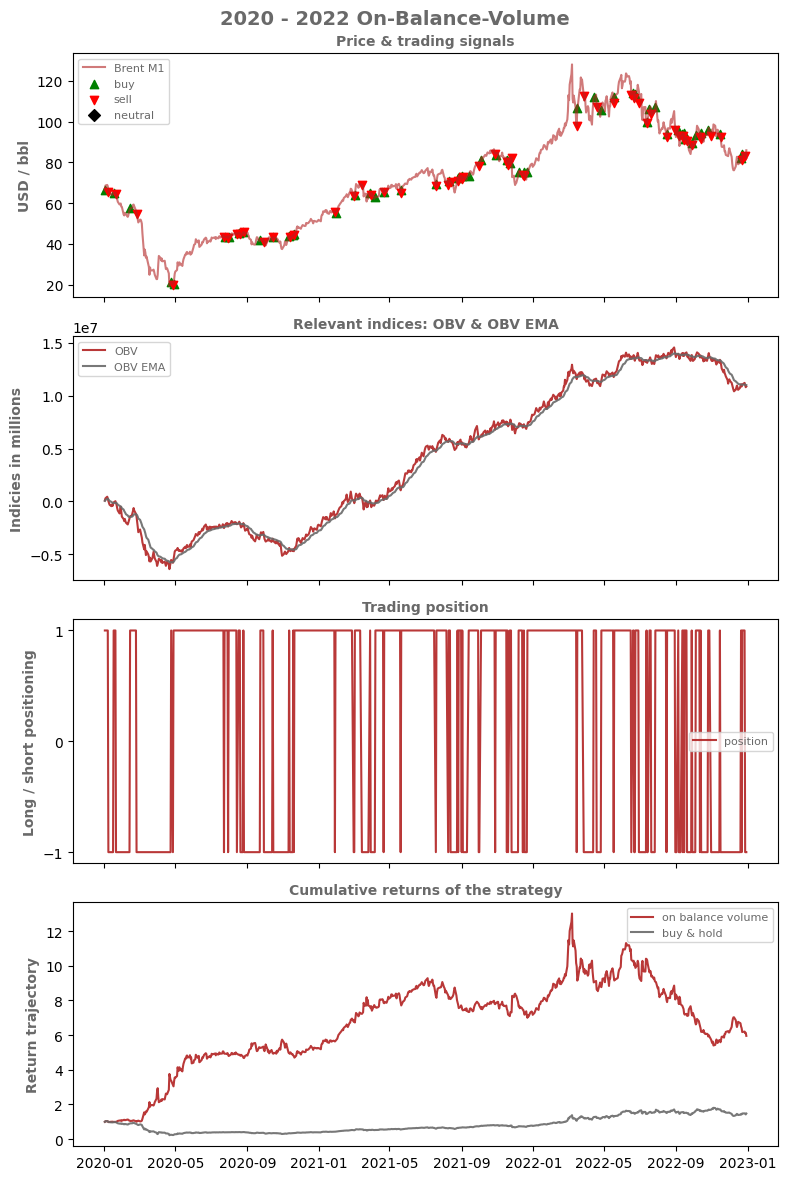

In [ ]:
obv_tester.plot_summary()

Just like with the previous ones, let's see if the performance is consistent in randomly selected annual periods...

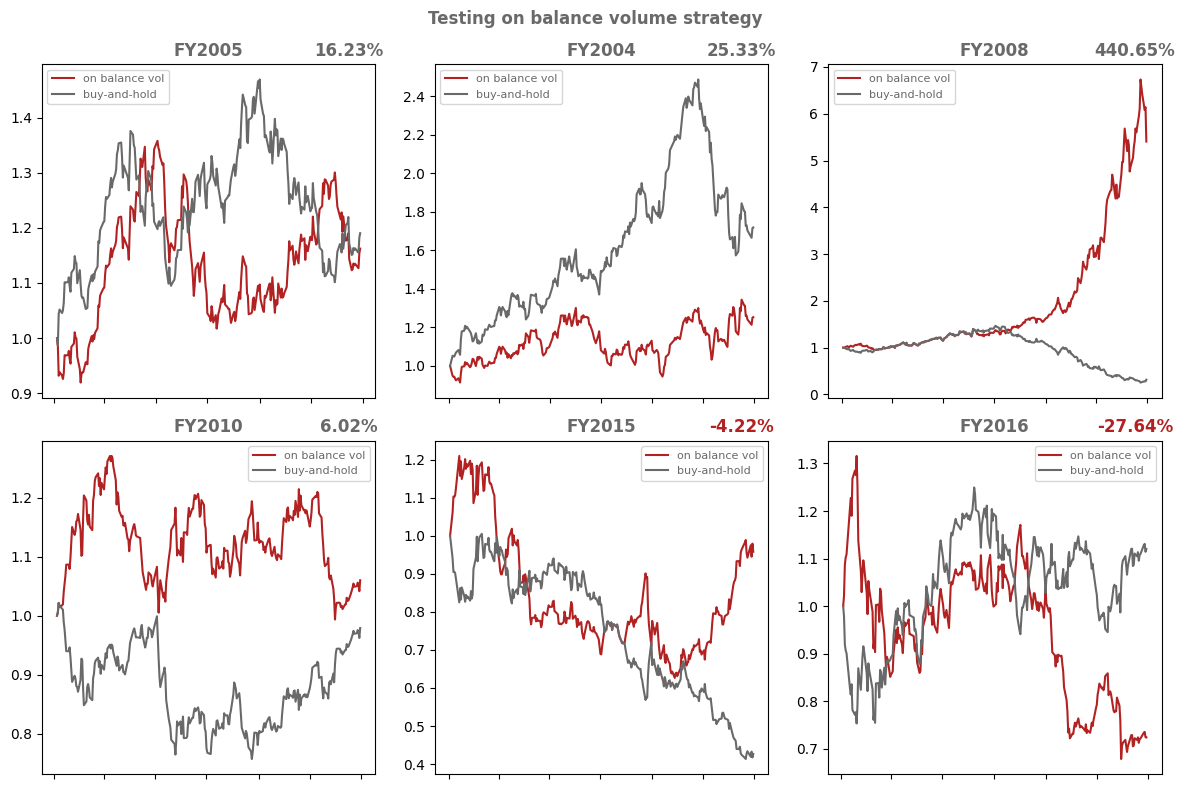

In [ ]:
fig, axes = plt.subplots(nrows = 2, ncols = 3, figsize=(12,8), dpi=100)
fig.suptitle("Testing on balance volume strategy", fontsize=12, fontweight="bold", color = 'dimgray', y=0.98)

year_list = list(np.arange(2004,2022))
year_sample = random.sample(year_list,len(axes.ravel()))

for year_choice, ax in zip(year_sample,axes.ravel()):
  start_point, end_point = str(year_choice) + '-01-01', str(year_choice) + '-12-31'
  obv_tester = on_balance_volume(20,start_point, end_point)
  obv_tester.plot_results(ax)
plt.tight_layout()

Nope... it does not qualify for outperformance

# **RSI**
The Relative Strength Index is in fact a technical momentum indicator which compares the magnitude of recent gains and losses over time. It moves between 0 and 100 helping to capture momentum as well as trend strength.

In [ ]:
class rsi(trading_strategy):
  ''' Class for testing strategy based on relative strength
  '''
  def __init__(self, length, delta, start, end, cost = cost_value, baseline = True):
    '''
    Additional parameters:
    ----------------------
    lenth: int
        determines length of the period used when calculating the index
    delta: int
        delta to determine both overbought & oversold territories:
           delta = 20 => oversold @ 30 & overbought @ 70
           delta = 25 => oversold @ 25 & overbought @ 75
           delta = 30 => oversold @ 20 & overbought @ 80
    '''
    super().__init__(start, end, cost) # inheriting 3 arguments from mother-class of trading strategy
    self.length = length
    self.delta = delta
    self.baseline = baseline
    self.outcome = None
    self.excess_return = 0

  def __repr__(self):
    return f'Object designed to test strategy based on relative strength index from {self.start} till {self.end}'

  def prepare_data(self):
    df = self.data.copy()
    df['diff'] = df['brent_m1'].diff()
    df['gain'] = df['diff'].clip(lower=0).round(3)
    df['loss'] = df['diff'].clip(upper=0).abs().round(3)
    df['avg_gain'] = df['gain'].rolling(window = self.length).mean().round(3)
    df['avg_loss'] = df['loss'].rolling(window = self.length).mean().round(3)
    df['rs'] = (df['avg_gain'] / df['avg_loss']).round(3)
    df['rsi'] = (100 - (100 / (1.0 + df['rs']))).round(3)

    conditions = [df['rsi'] >= 50 + self.delta,
                  (df['rsi'] >= 50) & (df['rsi'] < 50 + self.delta),
                  (df['rsi'] < 50) & (df['rsi'] >= 50 - self.delta),
                  df['rsi'] < 50 - self.delta]
    values = [-1, 1, -1, 1]
    df['position'] = np.select(conditions, values, default = 0)
    df['position'] = df['position'].ffill()

    conditions = [(df['position'].shift(1) < 1) & (df['position'] == 1),
                  (df['position'].shift(1) > -1) & (df['position'] == -1),
                  (df['position'].shift(1) == df['position']) & (df['expiry_day']==True)]
    values = ['go_long' ,'go_short', 'roll']
    df['action'] = np.select(conditions, values, default = 'hold')
    df['trades'] = df['position'].diff().fillna(0).abs().astype('int32')
    df.loc[df['action'] == 'roll','trades'] = 2
    df['costs'] = df['trades'] * self.cost

    conditions = [(df['expiry_day']== False) & (df['action'] == 'go_short'),
                  (df['expiry_day']== True) & (df['action'] == 'go_short'),
                  (df['expiry_day']== False) & (df['action'] == 'go_long'),
                  (df['expiry_day']== True) & (df['action'] == 'go_long'),
                  (df['position']== 1) & (df['action'] == 'roll'),
                  (df['position'] == -1) & (df['action'] == 'roll')]
    values = [df['brent_bid_m1'], df['brent_bid_m2'],
              df['brent_ask_m1'], df['brent_ask_m2'],
              (df['brent_bid_m1']+df['brent_ask_m2'])/2,
              (df['brent_ask_m1']+df['brent_bid_m2'])/2]
    df['price'] = np.select(conditions, values, default = df['brent_m1'])
    df['buy_signal'] = np.where(df['action']=='go_long',df['price'],np.nan)
    df['sell_signal'] = np.where(df['action']=='go_short',df['price'],np.nan)

    if self.baseline == True:
      conditions = [df.index == df.index[df.index.get_indexer([self.start], method = 'bfill')[0]],
                  df.index == df.index[df.index.get_indexer([self.end], method = 'ffill')[0]],
                  (df.index > self.start) & (df.index < self.end) & (df['expiry_day'] == True)]
      values = ['buy', 'sell', 'roll']
      df['base_action'] = np.select(conditions, values, default='hold')
      df['base_position'] = 0
      df.iloc[df.index.get_indexer([self.start], method = 'bfill')[0] : df.index.get_indexer([self.end], method = 'ffill')[0], df.columns.get_loc("base_position")] = 1
      df['base_trades'] = df['base_position'].diff().fillna(0).abs().astype('int32')
      df.loc[df['base_action'] == 'roll','base_trades'] = 2
      df['base_costs'] = df['base_trades'] * self.cost
      conditions = [(df['expiry_day']== False) & (df['base_action'] == 'buy'),
                    (df['expiry_day']== True) & (df['base_action'] == 'buy'),
                    (df['expiry_day']== False) & (df['base_action'] == 'sell'),
                    (df['expiry_day']== True) & (df['base_action'] == 'sell'),
                    (df['expiry_day']== False) & (df['base_action'] == 'hold'),
                    (df['expiry_day']== True) & (df['base_action'] == 'roll')]
      values = [df['brent_ask_m1'], df['brent_ask_m2'],
                df['brent_bid_m1'], df['brent_bid_m1'],
                df['brent_m1'], (df['brent_bid_m1']+df['brent_ask_m2'])/2]
      df['base_price'] = np.select(conditions, values, default = df['brent_m1'])
    self.full_data = df.iloc[df.index.get_indexer([self.start], method = 'bfill')[0] : df.index.get_indexer([self.end], method = 'ffill')[0]+1].copy()

  def set_params(self, new_length = None, new_delta = None):
    ''' Modifies settings regarding the length and delta
    '''
    if new_length is not None:
      self.length = new_length
    if new_delta is not None:
      self.delta = new_delta
    self.prepare_data()

  def test_strategy(self):
    ''' Performs a backtest of the strategy based on the rsi for a given period
    '''
    if self.full_data is None:
      self.prepare_data()
    df = self.full_data.copy()

    conditions = [(df['expiry_day']== False) & (df['action'] == 'go_short'),
                  (df['expiry_day'].shift(1)== False) & (df['action'].shift(1) == 'go_short'),
                  (df['expiry_day']== True) & (df['action'] == 'go_short'),
                  (df['expiry_day'].shift(1)== True) & (df['action'].shift(1) == 'go_short'),
                  (df['expiry_day']== False) & (df['action'] == 'go_long'),
                  (df['expiry_day'].shift(1)== False) & (df['action'].shift(1) == 'go_long'),
                  (df['expiry_day']== True) & (df['action'] == 'go_long'),
                  (df['expiry_day'].shift(1)== True) & (df['action'].shift(1) == 'go_long'),
                  (df['position'] == 1) & (df['action'] == 'roll'),
                  (df['position'].shift(1) == 1) & (df['action'].shift(1) == 'roll'),
                  (df['position'] == -1) & (df['action'] == 'roll'),
                  (df['position'].shift(1) == -1) & (df['action'].shift(1) == 'roll')
                  ]
    values = [np.log((df['brent_bid_m1'] - self.cost)/(df['price'].shift(1))),
              np.log(df['price']/(df['brent_bid_m1'].shift(1)-self.cost)),
              np.log((df['brent_bid_m2'] - self.cost)/(df['price'].shift(1))),
              np.log(df['price']/(df['brent_bid_m2'].shift(1)-self.cost)),
              np.log((df['brent_ask_m1'] + self.cost)/(df['price'].shift(1))),
              np.log(df['price']/(df['brent_ask_m1'].shift(1)+self.cost)),
              np.log((df['brent_ask_m2'] + self.cost)/(df['price'].shift(1))),
              np.log(df['price']/(df['brent_ask_m2'].shift(1)+self.cost)),
              np.log((df['brent_bid_m1'] + ((df['brent_bid_m1']-self.cost)-(df['brent_ask_m2']+self.cost))) / (df['price'].shift(1))),
              np.log(df['price']/(df['brent_ask_m2'].shift(1)+self.cost)),
              np.log((df['brent_ask_m1'] + ((df['brent_ask_m1']+self.cost)-(df['brent_bid_m2']-self.cost))) / (df['price'].shift(1))),
              np.log(df['price']/(df['brent_bid_m2'].shift(1)-self.cost))
              ]
    df['returns'] = np.select(conditions, values, default = np.log(df['price']/df['price'].shift(1)))
    df['returns'] = df['position'].shift(1) * df['returns']
    df["cum_returns"] = df["returns"].cumsum().apply(np.exp)
    outcome = (df.iloc[df.index.get_indexer([self.end], method = 'ffill')[0], df.columns.get_loc("cum_returns")]-1)*100
    self.outcome = outcome
    self.results = True

    if self.baseline == True:
      conditions = [df['base_action'].shift(1) == 'buy',
                  df['base_action'] == 'roll',
                  (df['base_action'].shift(1) == 'roll') & (df['base_action'] == 'hold'),
                  df['base_action'] == 'sell']
      values = [np.log(df['base_price']/(df['base_price'].shift(1)+self.cost)),
                np.log((2*df['brent_bid_m1']-df['brent_ask_m2']-self.cost) / df['brent_m1'].shift(1)),
                np.log(df['brent_m1'] / (df['brent_ask_m2'].shift(1)+self.cost)),
                np.log((df['base_price'] - self.cost)/(df['base_price'].shift(1)))]
      df['base_returns'] = np.select(conditions, values, default = np.log(df['base_price']/df['base_price'].shift(1)))
      df['base_returns'] = df['base_position'].shift(1) * df['base_returns']
      df["base_cum_returns"] = df["base_returns"].cumsum().apply(np.exp)
      # df = df.loc[self.start : self.end].copy()
      base_outcome = (df.iloc[df.index.get_indexer([self.end], method = 'ffill')[0], df.columns.get_loc("base_cum_returns")]-1)*100
      excess_return = outcome - base_outcome
      self.excess_return = excess_return
    self.full_data = df.loc[self.start : self.end].copy()

    return round(self.outcome,4), round(self.excess_return,4)

  def plot_summary(self):
    ''' Plots key charts summarizing the strategy
    '''
    if self.full_data is None:
      print(f'Method prepare_data() must be run in the first place')
    else:
      fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(8,12), dpi=100)
      fig.suptitle(f'{self.start[:4]} - {self.end[:4]} Relative Strength Index', fontsize = 14, fontweight="bold", color = 'dimgray')

      ax[0].plot(self.full_data['brent_m1'], color = 'firebrick', label = 'Brent M1', alpha = 0.6)
      ax[0].scatter(self.full_data.index, self.full_data['buy_signal'], label = 'buy', marker = '^', alpha = 1, color = 'green')
      ax[0].scatter(self.full_data.index, self.full_data['sell_signal'], label = 'sell', marker = 'v', alpha = 1, color = 'red')
      ax[0].set_title('Price & trading signals', fontsize = 10, fontweight="bold", color = 'dimgray')
      ax[0].set_ylabel(ylabel='USD / bbl',fontsize = 10, color = 'dimgrey', weight = 'bold')
      ax[0].set_xticklabels([])
      ax[0].legend(loc='best', fontsize = 8, labelcolor='dimgray')

      ax[1].plot(self.full_data['rsi'], color = 'firebrick', label = 'OBV', alpha = 0.9)
      ax[1].set_title('Relative strength index', fontsize = 10, fontweight="bold", color = 'dimgray')
      ax[1].set_ylabel(ylabel='Indicator',fontsize = 10, color = 'dimgrey', weight = 'bold')
      ax[1].set_xticklabels([])
      ax[1].legend(loc='best',fontsize = 8, labelcolor='dimgray')

      ax[2].plot(self.full_data['position'], color = 'firebrick', label = 'position', alpha = 0.9)
      ax[2].set_title('Trading position', fontsize = 10, fontweight="bold", color = 'dimgray')
      ax[2].set_ylabel(ylabel='Long / short positioning',fontsize = 10, color = 'dimgrey', weight = 'bold')
      ax[2].set_yticks([-1, 0, 1])
      ax[2].set_xticklabels([])
      ax[2].legend(loc='best',fontsize = 8, labelcolor='dimgray')

      ax[3].plot(self.full_data['cum_returns'], color = 'firebrick', label = 'rsi', alpha = 0.9)
      ax[3].set_title('Cumulative returns of the strategy', fontsize = 10, fontweight="bold", color = 'dimgray')
      ax[3].set_ylabel(ylabel='Return trajectory',fontsize = 10, color = 'dimgrey', weight = 'bold')
      if self.baseline == True:
        ax[3].plot(self.full_data['base_cum_returns'], color = 'dimgray', label = 'buy & hold', alpha = 0.9)
      ax[3].legend(loc='best',fontsize = 8, labelcolor='dimgray')

      plt.tight_layout()
      plt.savefig('RELATIVE_STRENGTH_INDEX')

  def plot_results(self, axis):
    ''' Plots the results of the rsi strategy
    '''
    if self.results == False:
      self.test_strategy()
    if self.outcome >=0:
      result_color = 'dimgray'
    else:
      result_color = 'firebrick'

    axis.plot(self.full_data['cum_returns'], color='firebrick', label = 'on balance vol')
    if self.baseline == True:
      axis.plot(self.full_data['base_cum_returns'], color='dimgray', label = 'buy-and-hold')
    axis.set_title(f'FY{self.start[:4]}', fontsize = 12, fontweight="bold", color = 'dimgray')
    axis.set_xticklabels([])
    axis.legend(loc='best', fontsize = 8, labelcolor='dimgray')
    axis.annotate(f'{self.outcome:.2f}%', xy=(0.92, 1.04), xycoords="axes fraction", size = 12, fontweight="bold", color = result_color, va="center", ha="center", alpha = 1);

  def optimize_params(self, length_range, delta_range):
    '''Searches for optimum length / delta combination for a given period
    Parameters:
    ===========
    window_range: tuple of integers
      assumes the following form (start, end, step)
    delta_range: tuple of floats
      assumes the following form (start, end, step)
    '''
    pairs = list(product(range(*length_range), np.arange(*delta_range)))

    results = []
    for pair in pairs:
      self.set_params(pair[0], pair[1])
      results.append(self.test_strategy())

    abs, rel = map(list,zip(*results))
    best_result = np.max(abs)
    best_pair = pairs[np.argmax(abs)]

    self.set_params(best_pair[0], best_pair[1])
    self.test_strategy()

    summary = pd.DataFrame(data = pairs, columns = ['length_choice', 'delta_choice'])
    summary = summary.assign(abs_res = abs)
    summary = summary.assign(rel_res = rel)
    self.summary = summary.copy(deep = False)

    return best_result, best_pair

Let's see it in action

In [ ]:
rsi_tester = rsi(10,25,'2020-01-01','2022-12-31')
rsi_tester

Object designed to test strategy based on relative strength index from 2020-01-01 till 2022-12-31

In [ ]:
rsi_tester.prepare_data()
rsi_tester.full_data.head(10)

,brent_m1,brent_bid_m1,brent_ask_m1,brent_m2,brent_bid_m2,brent_ask_m2,expiry_day,volume,diff,gain,...,trades,costs,price,buy_signal,sell_signal,base_action,base_position,base_trades,base_costs,base_price
date,,,,,,,,,,,,,,,,,,,,,
2020-01-02,66.25,66.190,66.310,65.56,65.495,65.625,False,81185,0.25,0.25,...,0,0.00,66.25,NaN,NaN,buy,1,1,0.01,66.31
2020-01-03,68.60,68.590,68.610,67.76,67.745,67.775,False,202661,2.35,2.35,...,0,0.00,68.60,NaN,NaN,hold,1,0,0.00,68.60
2020-01-06,68.91,68.890,68.930,68.07,68.045,68.095,False,152513,0.31,0.31,...,0,0.00,68.91,NaN,NaN,hold,1,0,0.00,68.91
2020-01-07,68.27,68.260,68.280,67.57,67.555,67.585,False,142789,-0.64,0.00,...,0,0.00,68.27,NaN,NaN,hold,1,0,0.00,68.27
2020-01-08,65.44,65.410,65.470,64.79,64.755,64.825,False,270031,-2.83,0.00,...,2,0.02,65.41,NaN,65.41,hold,1,0,0.00,65.44
2020-01-09,65.37,65.350,65.390,64.66,64.635,64.685,False,187438,-0.07,0.00,...,0,0.00,65.37,NaN,NaN,hold,1,0,0.00,65.37
2020-01-10,64.98,64.940,65.020,64.25,64.210,64.290,False,155702,-0.39,0.00,...,0,0.00,64.98,NaN,NaN,hold,1,0,0.00,64.98
2020-01-13,64.20,64.155,64.245,63.48,63.430,63.530,False,137517,-0.78,0.00,...,0,0.00,64.20,NaN,NaN,hold,1,0,0.00,64.20
2020-01-14,64.49,64.460,64.520,63.71,63.675,63.745,False,158743,0.29,0.29,...,0,0.00,64.49,NaN,NaN,hold,1,0,0.00,64.49


Why don't we test it?

In [ ]:
rsi_tester.test_strategy()

(-78.7817, -126.6409)

Let's try some other settings...

In [ ]:
rsi_tester.optimize_params((10,31,2),(20,31,1))

(662.8941, (30, 28))

In [ ]:
rsi_tester.summary.nlargest(10,'abs_res')

,length_choice,delta_choice,abs_res,rel_res
118,30,28,662.8941,615.0348
117,30,27,648.7185,600.8593
116,30,26,646.1081,598.2489
119,30,29,641.4982,593.6390
120,30,30,577.4800,529.6208
107,28,28,531.3532,483.4939
108,28,29,492.1626,444.3034
96,26,28,446.1925,398.3333
95,26,27,399.8167,351.9575
115,30,25,367.0730,319.2138


In [ ]:
rsi_tester.set_params(30,28)
rsi_tester.test_strategy()

(662.8941, 615.0348)

Let's check on the visuals for the entire period...

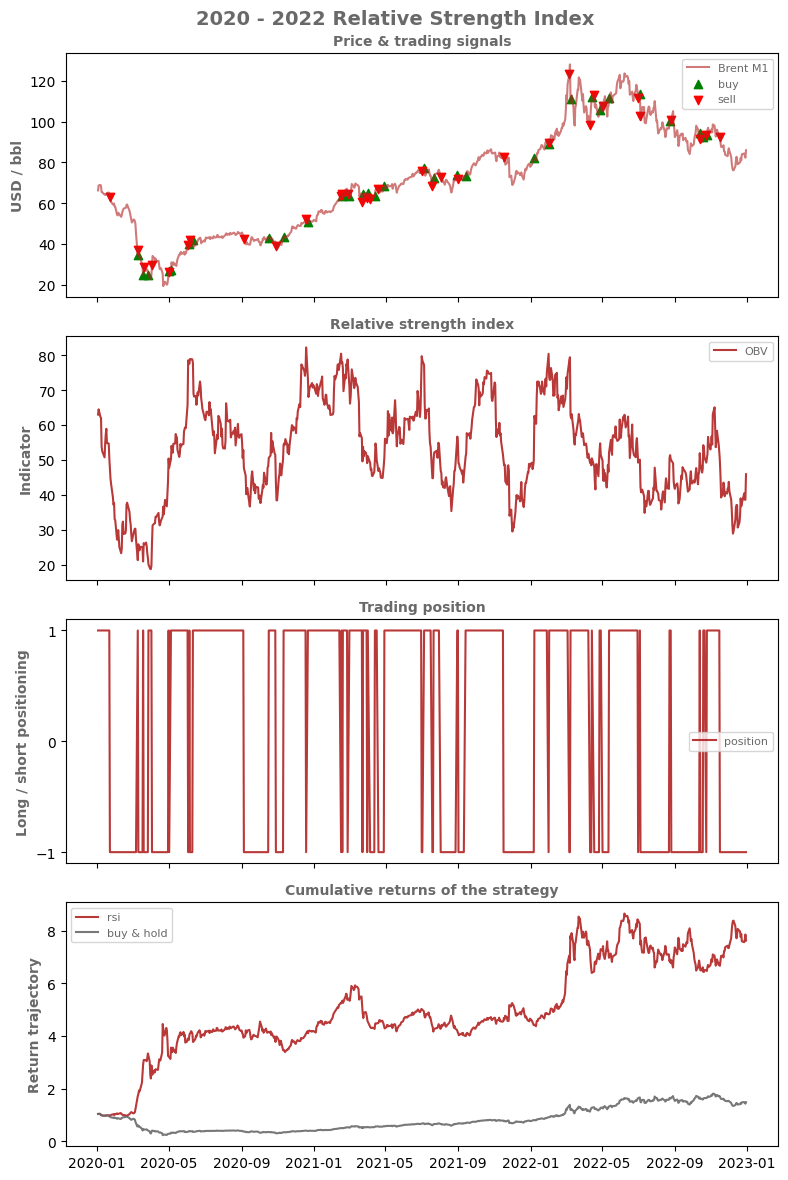

In [ ]:
rsi_tester.plot_summary()

And, as big fans of randomness, let's see its performance in randomly selected annual periods...

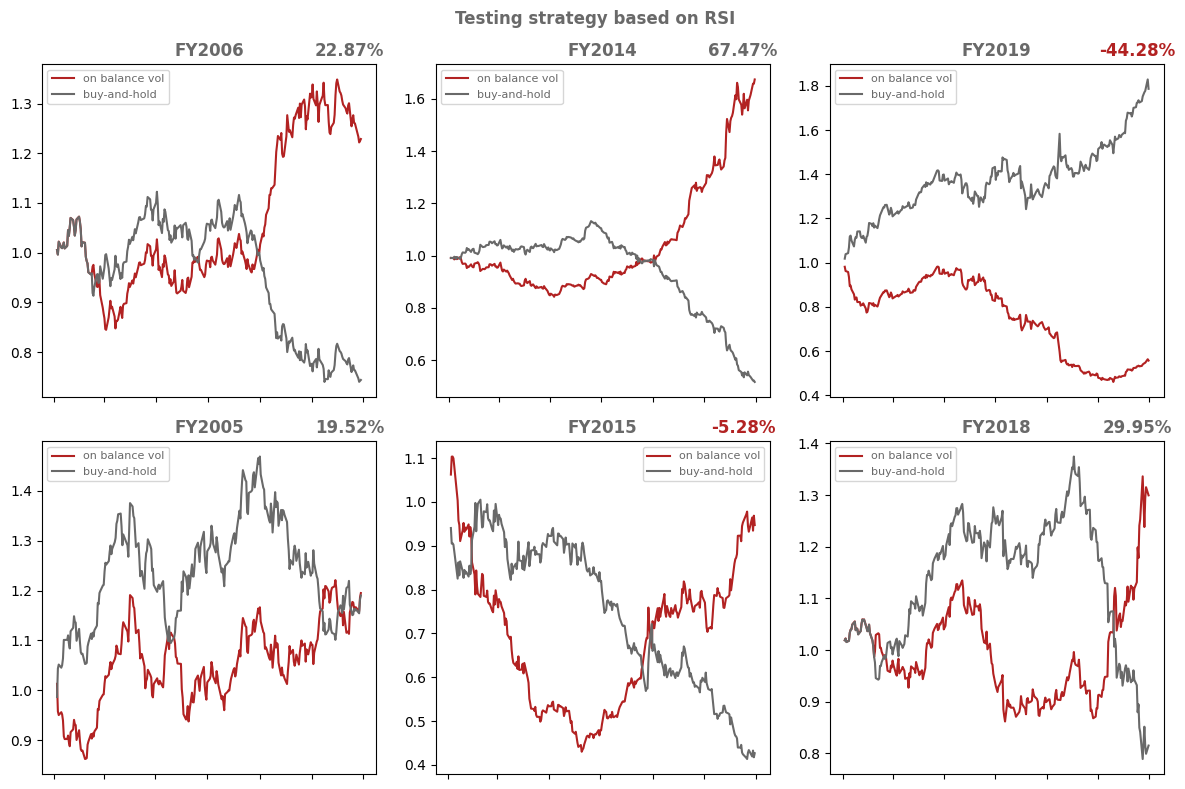

In [ ]:
fig, axes = plt.subplots(nrows = 2, ncols = 3, figsize=(12,8), dpi=100)
fig.suptitle("Testing strategy based on RSI", fontsize=12, fontweight="bold", color = 'dimgray', y=0.98)

year_list = list(np.arange(2004,2022))
year_sample = random.sample(year_list,len(axes.ravel()))

for year_choice, ax in zip(year_sample,axes.ravel()):
  start_point, end_point = str(year_choice) + '-01-01', str(year_choice) + '-12-31'
  rsi_tester = rsi(30, 30, start_point, end_point)
  rsi_tester.plot_results(ax)
plt.tight_layout()

Not so great any more

# **Summary**

1.   Traders attempt to find an edge supporting their profitability
2.   Quant nature of technical analysis indicators makes them convenient to implement in algo strategies
1.   Test period of 2020-2022 was chosen because of its attributes:
>* it's fairly recent
>* it has distinct period of strong bear market (Covid)
>* it has distinct period of strong bull market (Russian invasion of Ukraine)
2.   Strategies tested have parameters that must be fine-tuned
1.   Best settings from the backtest period usually underperform in other periods
2.   In a quest for the edge:
>* more basic strategies could be tested
>* basic strategies could be combined into more sophisticated solutions
>* machine learning concepts could be tested

stay tuned...








